<a href="https://colab.research.google.com/github/avladova/Railway-track-deviations/blob/main/%D0%90%D0%B2%D1%82%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B2_%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных

In [53]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from datetime import datetime

import plotly.express as px

import matplotlib.dates as mdates
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import MinMaxScaler

In [54]:
# Url of the raw xls file on GitHub
url='https://raw.githubusercontent.com/avladova/Railway-track-deviations/refs/heads/main/fragment.csv'
# Read the xls file into a DataFrame
raw = pd.read_csv(url, sep=',')
#raw.drop(columns='Num', inplace=True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   5000 non-null   int64  
 1   КМ           5000 non-null   int64  
 2   М            5000 non-null   int64  
 3   АМПЛИТУДА    4995 non-null   float64
 4   HOPMA        5000 non-null   int64  
 5   КОДОТСТУП    5000 non-null   int64  
 6   ГОД          5000 non-null   int64  
 7   МЕСЯЦ        5000 non-null   int64  
 8   ДЕНЬ         5000 non-null   int64  
 9   СТЕПЕНЬ      5000 non-null   int64  
 10  ДЛИНА        5000 non-null   int64  
 11  ОТСТУПЛЕНИЕ  5000 non-null   object 
dtypes: float64(1), int64(10), object(1)
memory usage: 468.9+ KB


# Дисбаланс

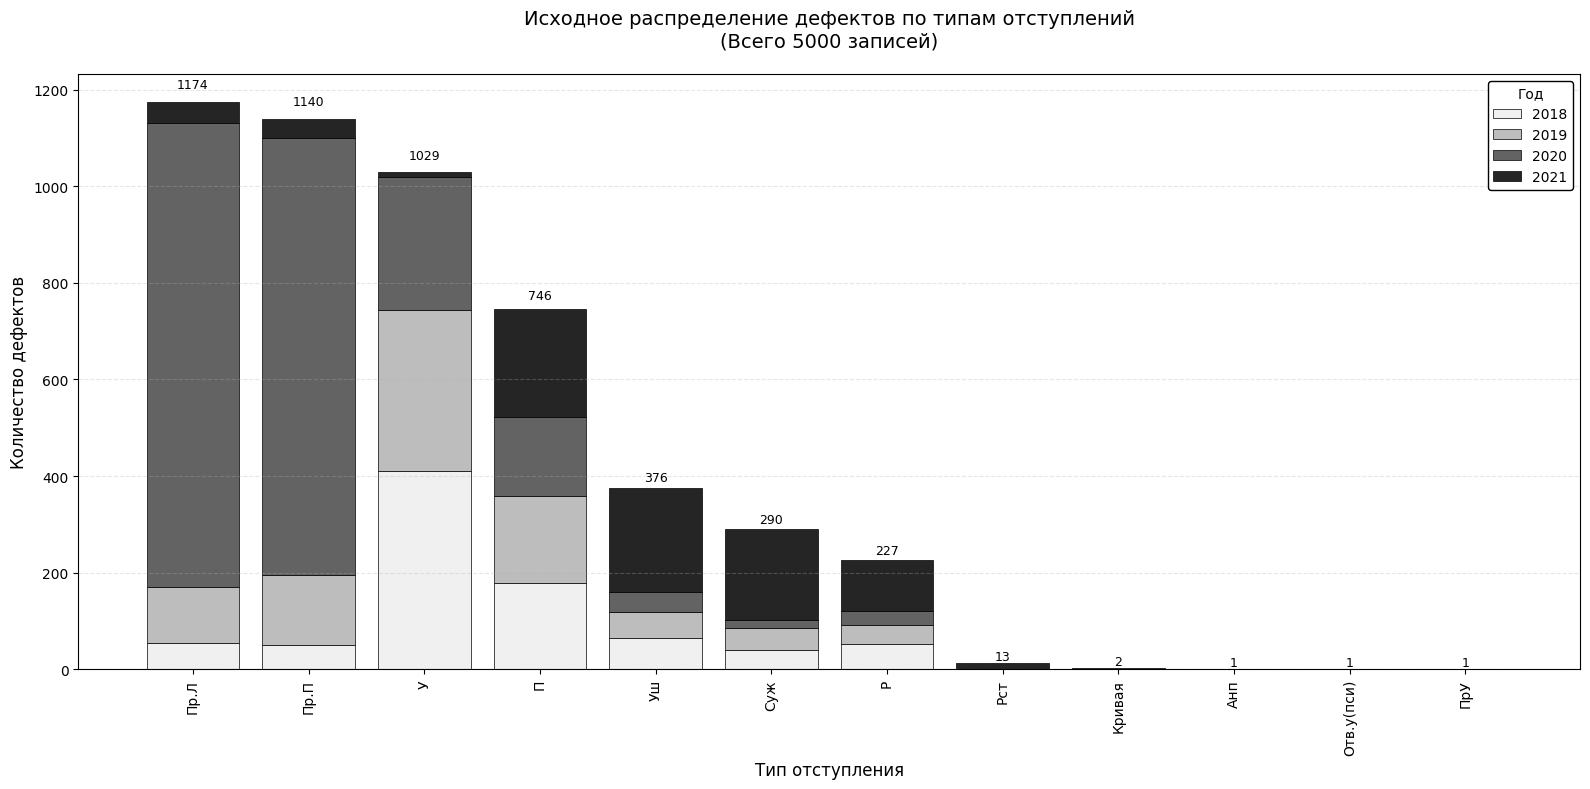

In [55]:
df=raw.copy()
# Подготовка данных
original_dist = df.groupby(['ОТСТУПЛЕНИЕ', 'ГОД']).size().unstack().fillna(0)
original_dist['Всего'] = original_dist.sum(axis=1)
original_dist = original_dist.sort_values('Всего', ascending=False).drop('Всего', axis=1)

# Создание монохромной палитры
gray_palette = ['#f0f0f0', '#bdbdbd', '#636363', '#252525']  # От светлого к темному

# Настройка графика
plt.figure(figsize=(16, 8))
years = sorted(df['ГОД'].unique())

# Построение столбчатой диаграммы
bottom = np.zeros(len(original_dist))
for i, year in enumerate(years):
    if year in original_dist.columns:
        plt.bar(
            original_dist.index,
            original_dist[year],
            bottom=bottom,
            color=gray_palette[i % len(gray_palette)],  # Циклическое использование палитры  color=colors[i],
            edgecolor='black',
            linewidth=0.5,
            label=str(year)
        )
        bottom += original_dist[year]

# Оформление
plt.title('Исходное распределение дефектов по типам отступлений\n(Всего {} записей)'.format(len(df)),
          fontsize=14, pad=20)
plt.xlabel('Тип отступления', fontsize=12)
plt.ylabel('Количество дефектов', fontsize=12)
plt.xticks(rotation=90, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Упрощенная легенда
plt.legend(title='Год', frameon=True, framealpha=1, edgecolor='black')

# Добавление значений
for i, (idx, row) in enumerate(original_dist.iterrows()):
    total = row.sum()
    plt.text(
        i,
        total + total*0.02,
        f'{int(total)}',
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

plt.tight_layout()
plt.show()

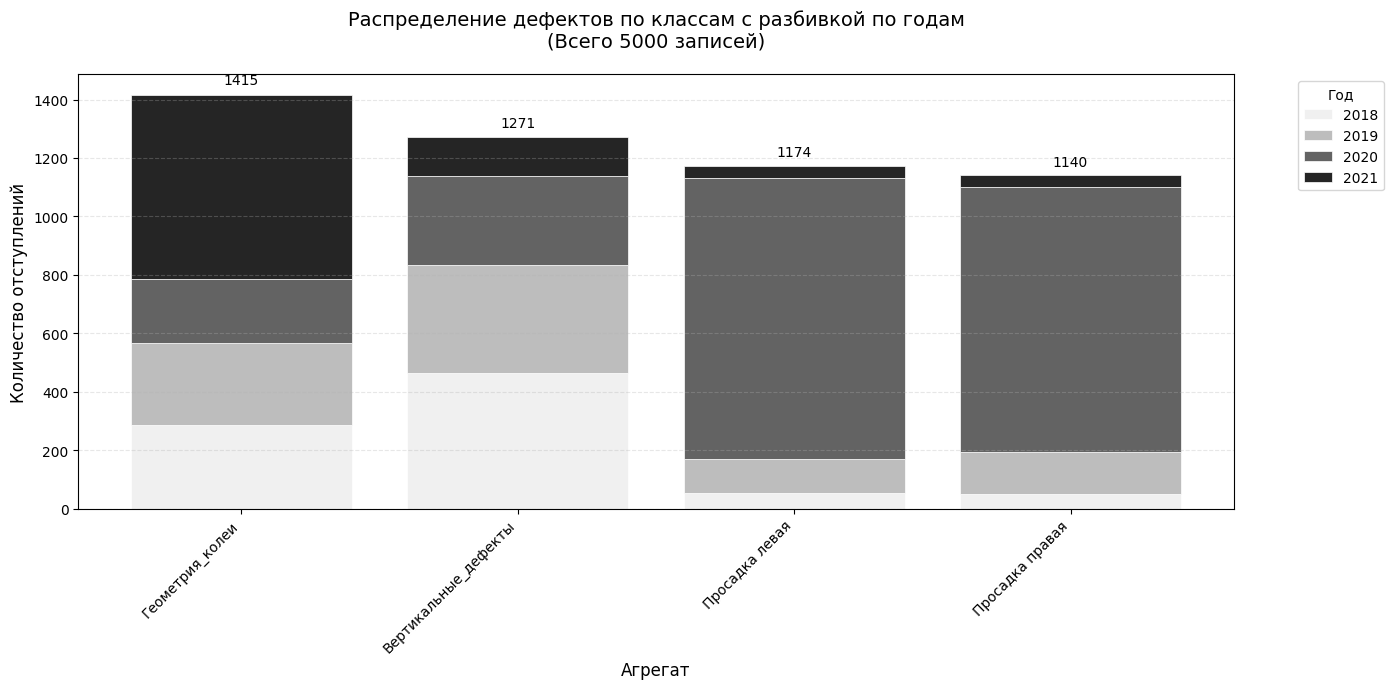

In [56]:
# Создаем копию данных
df = raw.copy()
class_mapping = {
    'Вертикальные_дефекты': [
        'У', 'ПрУ', 'Укл', 'Уск',      # Общие уровневые отклонения
        'Р', 'Р.нр', 'Рст',            # Рихтовочные дефекты
        'пржР+Пр.л', 'Аг', 'Анп',      # Комплексные случаи
        'Отв.ш'                        # Шпальные смещения
    ],
    'Геометрия_колеи': [
        'Уш', 'Суж',                   # Ширина колеи
        'П', 'Отв.у(пси)', 'Кривая'    # Перенесенные параметры
    ],
    'Просадка левая': ['Пр.Л'],
    'Просадка правая': ['Пр.П']
}
# Применяем классификацию к данным
df['Класс'] = df['ОТСТУПЛЕНИЕ'].apply(
    lambda x: next((k for k, v in class_mapping.items() if x in v), 'Прочие'))

# Подготовка данных для визуализации
class_dist = df.groupby(['Класс', 'ГОД']).size().unstack().fillna(0)
class_dist['Всего'] = class_dist.sum(axis=1)
class_dist = class_dist.sort_values('Всего', ascending=False).drop('Всего', axis=1)

# Настройка стиля
plt.figure(figsize=(14, 7))
years = sorted(df['ГОД'].unique())

# Создание монохромной палитры
gray_palette = ['#f0f0f0', '#bdbdbd', '#636363', '#252525']  # От светлого к темному

# Построение stacked bar plot
bottom = np.zeros(len(class_dist))
for i, year in enumerate(years):
    if year in class_dist.columns:
        plt.bar(
            class_dist.index,
            class_dist[year],
            bottom=bottom,
            color=gray_palette[i % len(gray_palette)],  # Циклическое использование палитры color=colors[i],
            edgecolor='white',
            linewidth=0.5,
            label=str(year)
        )
        bottom += class_dist[year]

# Настройка оформления
plt.title('Распределение дефектов по классам с разбивкой по годам\n(Всего {} записей)'.format(len(df)),
          fontsize=14, pad=20)
plt.xlabel('Агрегат', fontsize=12)
plt.ylabel('Количество отступлений', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Год', bbox_to_anchor=(1.05, 1), loc='upper left')

# Добавление суммарных значений
for i, (idx, row) in enumerate(class_dist.iterrows()):
    total = row.sum()
    plt.text(
        i,
        total + total*0.02,
        f'{int(total)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

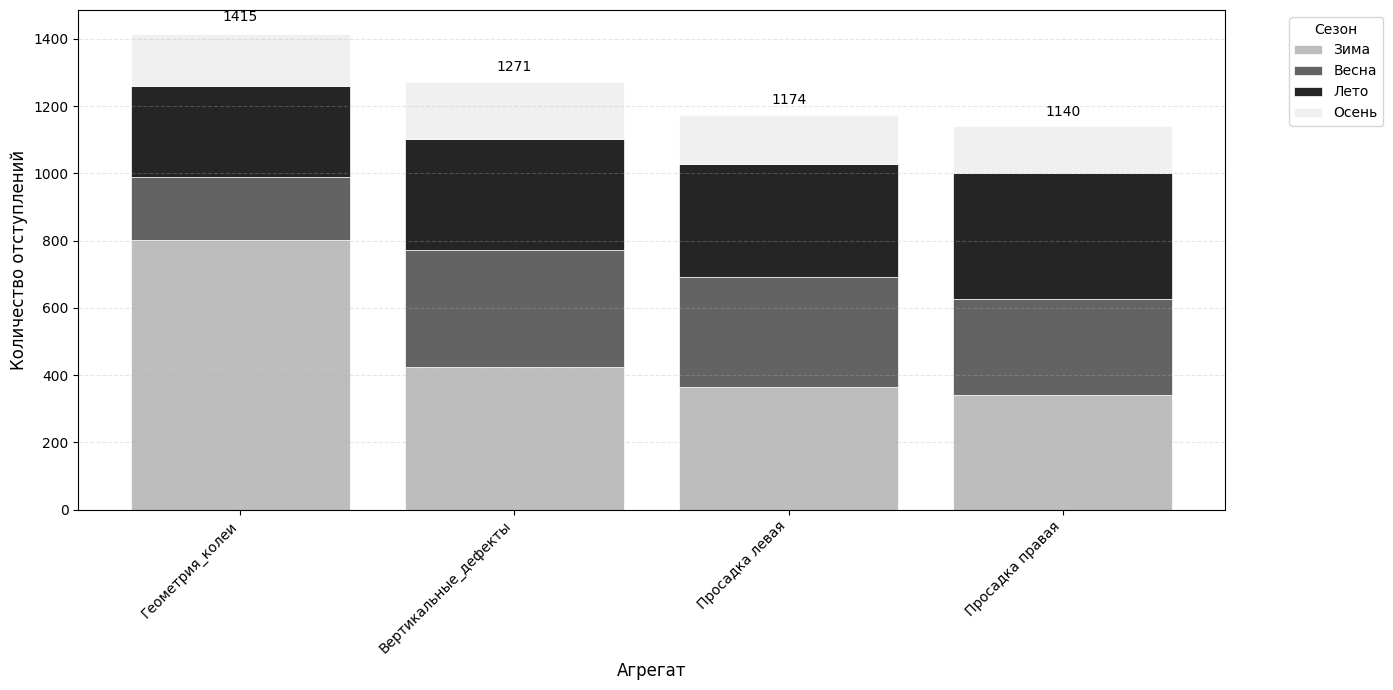

In [57]:
# Создаем копию данных
df = raw.copy()

class_mapping = {
    'Вертикальные_дефекты': [
        'У', 'ПрУ', 'Укл', 'Уск',      # Общие уровневые отклонения
        'Р', 'Р.нр', 'Рст',            # Рихтовочные дефекты
        'пржР+Пр.л', 'Аг', 'Анп',      # Комплексные случаи
        'Отв.ш'                        # Шпальные смещения
    ],
    'Геометрия_колеи': [
        'Уш', 'Суж',                   # Ширина колеи
        'П', 'Отв.у(пси)', 'Кривая'    # Перенесенные параметры
    ],
    'Просадка левая': ['Пр.Л'],
    'Просадка правая': ['Пр.П']
}

# Применяем классификацию к данным
df['Класс'] = df['ОТСТУПЛЕНИЕ'].apply(
    lambda x: next((k for k, v in class_mapping.items() if x in v), 'Прочие'))

# Добавляем сезоны (1-Зима, 2-Весна, 3-Лето, 4-Осень)
df['Дата'] = pd.to_datetime(df[['ГОД', 'МЕСЯЦ', 'ДЕНЬ']].rename(columns={'ГОД': 'year', 'МЕСЯЦ': 'month', 'ДЕНЬ': 'day'}))
df['Сезон'] = df['Дата'].dt.month % 12 // 3 + 1

# Подготовка данных для визуализации
class_dist = df.groupby(['Класс', 'Сезон']).size().unstack().fillna(0)
class_dist['Всего'] = class_dist.sum(axis=1)
class_dist = class_dist.sort_values('Всего', ascending=False).drop('Всего', axis=1)

# Настройка стиля
plt.figure(figsize=(14, 7))
seasons = ['Зима', 'Весна', 'Лето', 'Осень']

# Создание монохромной палитры
gray_palette = ['#f0f0f0', '#bdbdbd', '#636363', '#252525']  # От светлого к темному

# Построение stacked bar plot
bottom = np.zeros(len(class_dist))
for i, season in enumerate(seasons, 1):
    if i in class_dist.columns:
        plt.bar(
            class_dist.index,
            class_dist[i],
            bottom=bottom,
            color=gray_palette[i % len(gray_palette)], #            color=colors[i-1],
            edgecolor='white',
            linewidth=0.5,
            label=season
        )
        bottom += class_dist[i]

# Настройка оформления
plt.xlabel('Агрегат', fontsize=12)
plt.ylabel('Количество отступлений', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Сезон', bbox_to_anchor=(1.05, 1), loc='upper left')

# Добавление суммарных значений
for i, (idx, row) in enumerate(class_dist.iterrows()):
    total = row.sum()
    plt.text(
        i,
        total + total*0.02,
        f'{int(total)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

# Корреляция

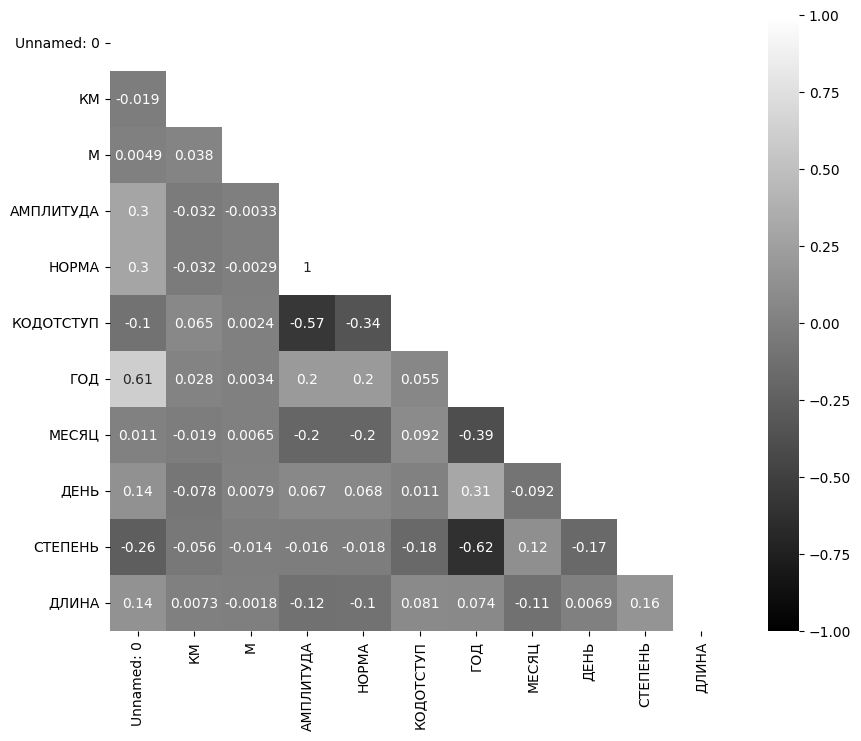

In [58]:
# Фильтруем столбцы с заполненностью >50%
threshold = 0.5 * len(raw)
filtered_columns = raw.columns[raw.notna().sum() > threshold]
filtered_data = raw[filtered_columns]

# Вычисляем корреляцию только для отфильтрованных числовых столбцов
corr_matrix = filtered_data.select_dtypes(include=[np.number]).corr()


# Create a mask to hide the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) #|(np.abs(corr_matrix) >= 0.9))

# Обрезаем длинные названия столбцов (первые 15 символов)
short_names = [name[:15] + ('...' if len(name) > 15 else '') for name in corr_matrix.columns]
corr_matrix.columns = short_names
corr_matrix.index = short_names

# Plot the upper triangle of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, cmap='grey', vmin=-1, vmax=1, annot=True)
plt.show()

# Агрегаты

In [59]:
# Копируем исходные данные
df = raw.copy()

segment_length = 65000
df['Сегмент'] = (df['КМ'] * 1000 + df['М']) // segment_length

df['Разность'] = df['АМПЛИТУДА'] - df['HOPMA']

# Применяем классификацию дефектов
class_mapping = {
    'Вертикальные_дефекты': ['У', 'ПрУ', 'Укл', 'Уск', 'Р', 'Р.нр', 'Рст', 'пржР+Пр.л', 'Аг', 'Анп', 'Отв.ш'],
    'Геометрия_колеи': ['Уш', 'Суж', 'П', 'Отв.у(пси)', 'Кривая'],
    'Просадка левая': ['Пр.Л'],
    'Просадка правая': ['Пр.П']
}
df['Класс'] = df['ОТСТУПЛЕНИЕ'].apply(
    lambda x: next((k for k, v in class_mapping.items() if x in v), 'Прочие'))

# Преобразование даты и создание сегментов
df['Дата'] = pd.to_datetime(df[['ГОД', 'МЕСЯЦ', 'ДЕНЬ']].rename(columns={'ГОД': 'year', 'МЕСЯЦ': 'month', 'ДЕНЬ': 'day'}))
df['Год-месяц'] = df['Дата'].dt.to_period('M')

# Группировка данных
monthly_data = df.groupby(['Сегмент', 'Класс', 'Год-месяц'])['Разность'].agg(['mean', 'std']).reset_index()

monthly_data.columns = ['Сегмент', 'Класс', 'Месяц', 'Среднее', 'Стандартное отклонение']

# Вычисление средневзвешенного стандартного отклонения
monthly_weighted_std = monthly_data.groupby(['Сегмент', 'Класс', 'Месяц'])['Стандартное отклонение'].mean().reset_index()

# Преобразование формата даты
monthly_weighted_std['Месяц'] = pd.to_datetime(monthly_weighted_std['Месяц'].dt.to_timestamp())
monthly_weighted_std['Год-месяц'] = monthly_weighted_std['Месяц'].dt.strftime('%Y-%m')

        # Сортировка данных
monthly_weighted_std = monthly_weighted_std.sort_values(['Сегмент', 'Месяц'])

# TQI

In [60]:
# Копируем исходные данные
df = raw.copy()

segment_length = 200
df['Сегмент'] = (df['КМ'] * 1000 + df['М']) // segment_length

df['Разность'] = df['АМПЛИТУДА'] - df['HOPMA']

# Применяем классификацию дефектов
class_mapping = {
    'Вертикальные_дефекты': ['У', 'ПрУ', 'Укл', 'Уск', 'Р', 'Р.нр', 'Рст', 'пржР+Пр.л', 'Аг', 'Анп', 'Отв.ш'],
    'Геометрия_колеи': ['Уш', 'Суж', 'П', 'Отв.у(пси)', 'Кривая'],
    'Просадка левая': ['Пр.Л'],
    'Просадка правая': ['Пр.П']
}
df['Класс'] = df['ОТСТУПЛЕНИЕ'].apply(
    lambda x: next((k for k, v in class_mapping.items() if x in v), 'Прочие'))

# Преобразование даты и создание сегментов
df['Дата'] = pd.to_datetime(df[['ГОД', 'МЕСЯЦ', 'ДЕНЬ']].rename(columns={'ГОД': 'year', 'МЕСЯЦ': 'month', 'ДЕНЬ': 'day'}))
df['Год-месяц'] = df['Дата'].dt.to_period('M')

# Группировка данных
monthly_data = df.groupby(['Сегмент', 'Класс', 'Год-месяц'])['Разность'].agg(['mean', 'std']).reset_index()

monthly_data.columns = ['Сегмент', 'Класс', 'Месяц', 'Среднее', 'Стандартное отклонение']

# Вычисление средневзвешенного стандартного отклонения
monthly_weighted_std = monthly_data.groupby(['Сегмент', 'Класс', 'Месяц'])['Стандартное отклонение'].mean().reset_index()

# Преобразование формата даты
monthly_weighted_std['Месяц'] = pd.to_datetime(monthly_weighted_std['Месяц'].dt.to_timestamp())
monthly_weighted_std['Год-месяц'] = monthly_weighted_std['Месяц'].dt.strftime('%Y-%m')

        # Сортировка данных
monthly_weighted_std = monthly_weighted_std.sort_values(['Сегмент', 'Месяц'])

Сегмент 5 пропущен (4 точек)
Сегмент 6 пропущен (3 точек)
Сегмент 7 пропущен (9 точек)
Сегмент 8 пропущен (10 точек)


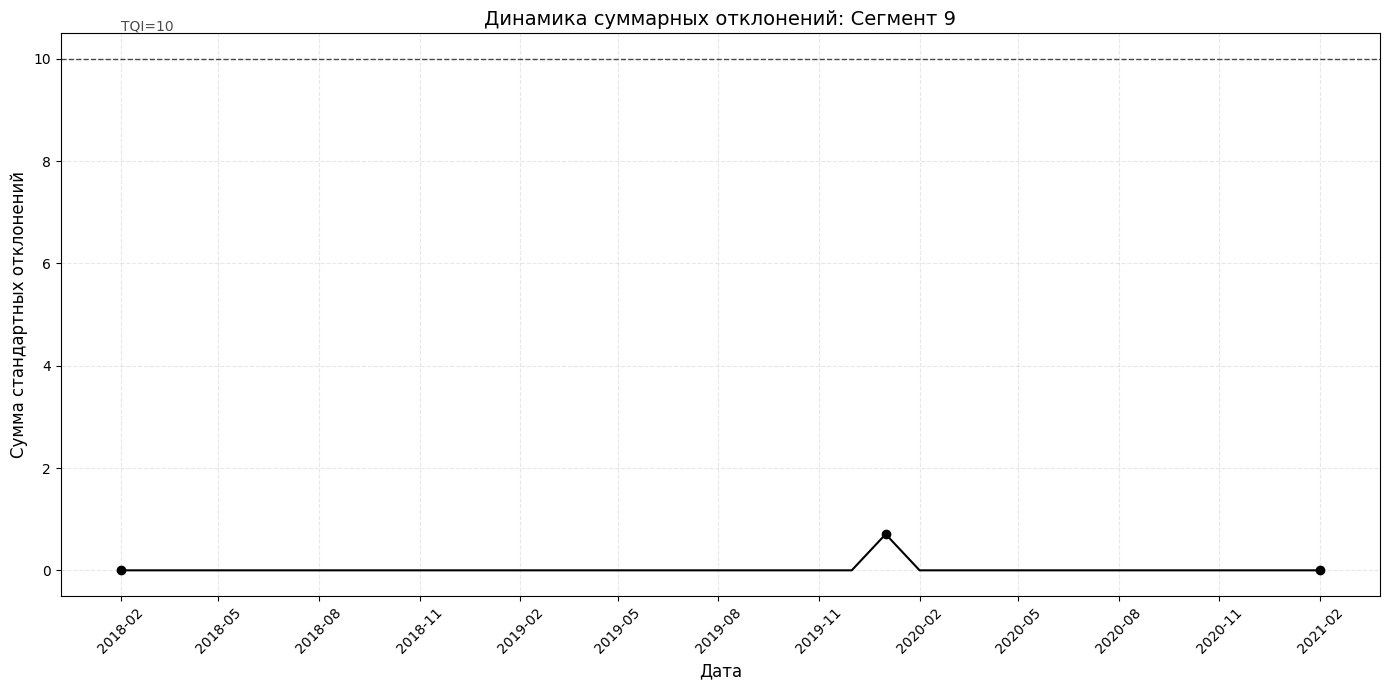

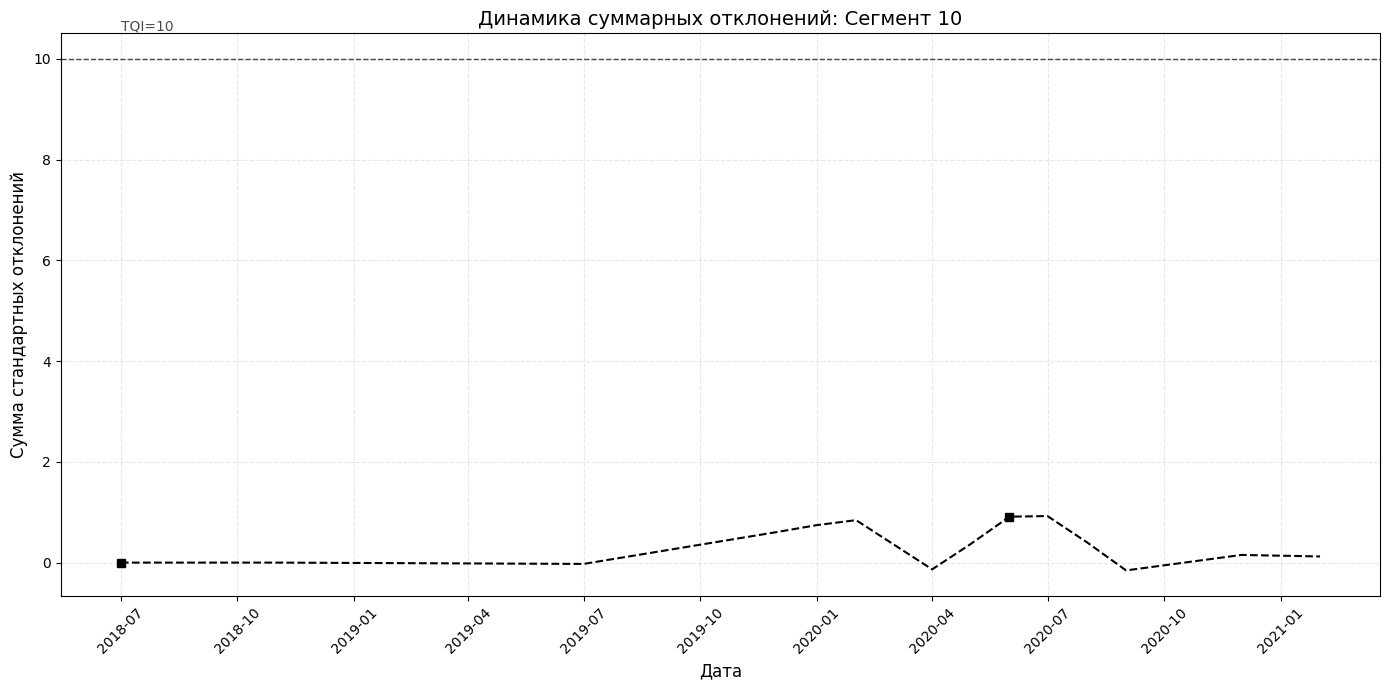

Сегмент 11 пропущен (4 точек)
Сегмент 12 пропущен (2 точек)
Сегмент 13 пропущен (4 точек)
Сегмент 14 пропущен (2 точек)
Сегмент 15 пропущен (2 точек)
Сегмент 16 пропущен (5 точек)
Сегмент 17 пропущен (5 точек)
Сегмент 18 пропущен (5 точек)


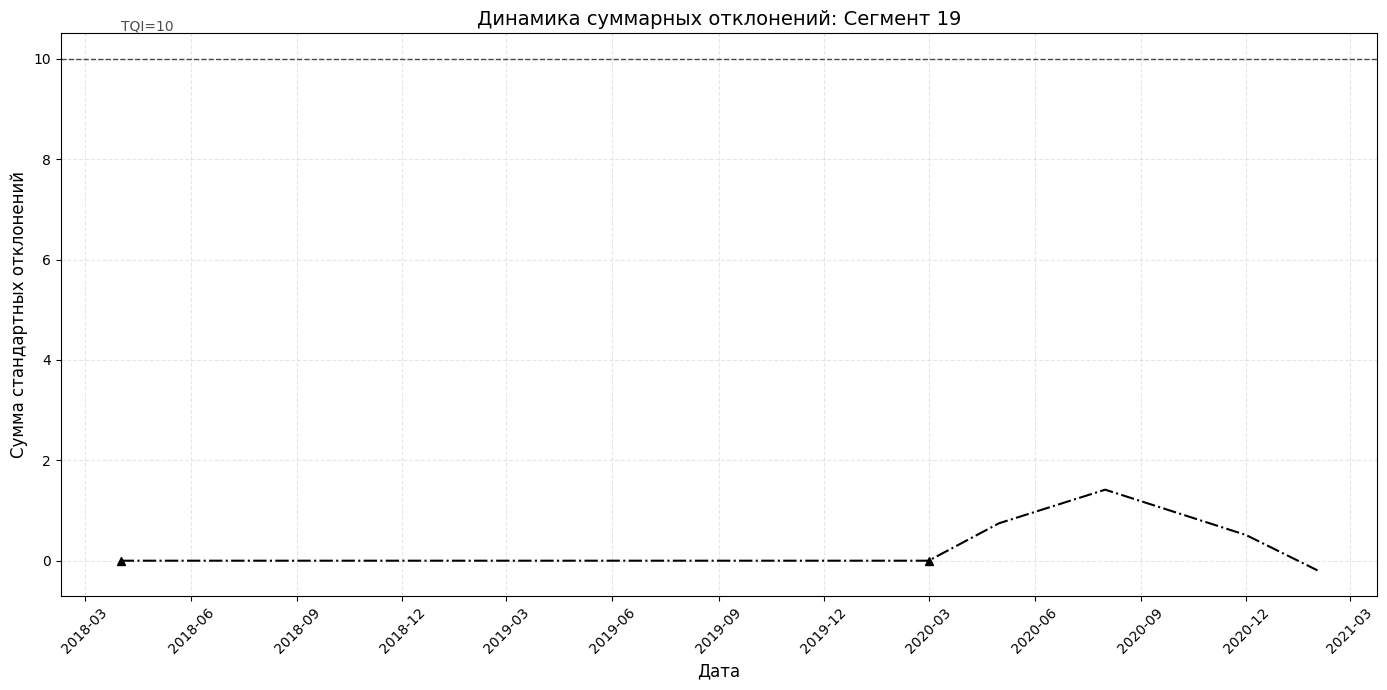

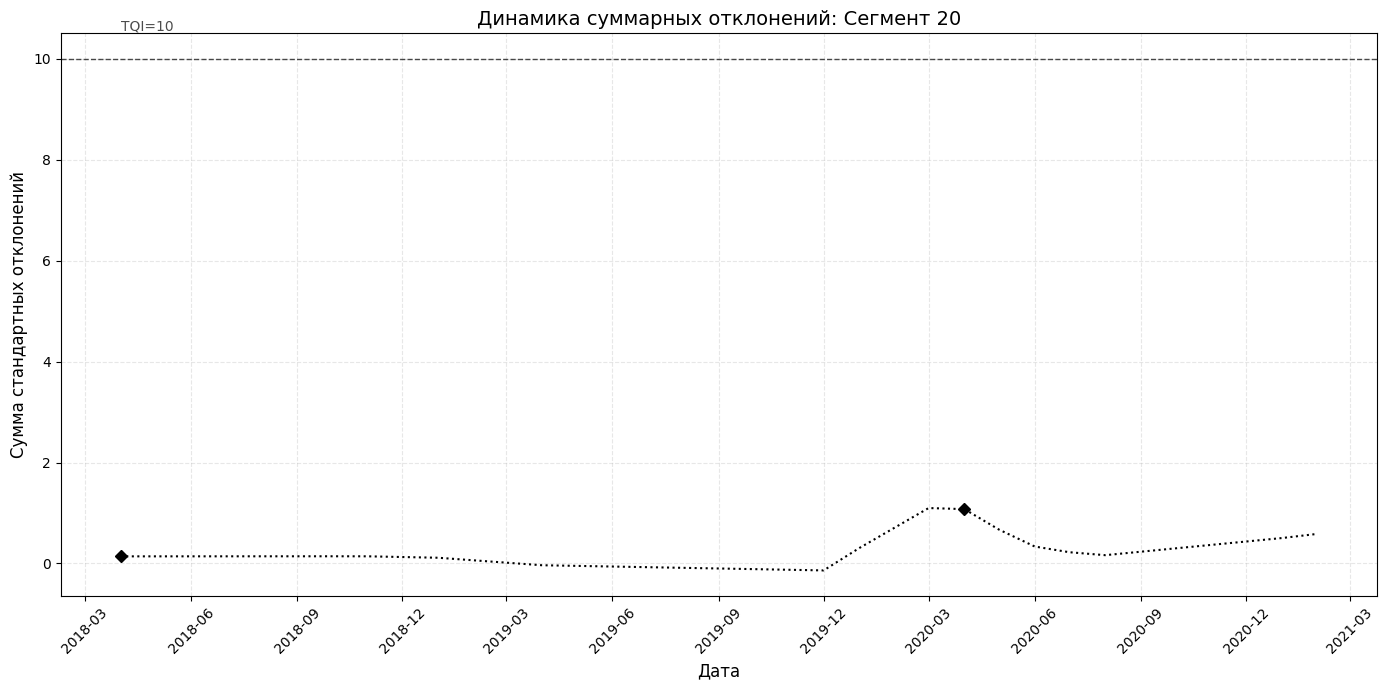

Сегмент 21 пропущен (3 точек)
Сегмент 23 пропущен (1 точек)
Сегмент 24 пропущен (1 точек)
Сегмент 26 пропущен (6 точек)
Сегмент 27 пропущен (8 точек)
Сегмент 28 пропущен (2 точек)
Сегмент 29 пропущен (3 точек)
Сегмент 31 пропущен (1 точек)
Сегмент 32 пропущен (3 точек)
Сегмент 33 пропущен (1 точек)
Сегмент 34 пропущен (2 точек)
Сегмент 35 пропущен (1 точек)
Сегмент 36 пропущен (1 точек)
Сегмент 37 пропущен (5 точек)
Сегмент 38 пропущен (4 точек)
Сегмент 39 пропущен (1 точек)
Сегмент 41 пропущен (2 точек)
Сегмент 43 пропущен (1 точек)
Сегмент 44 пропущен (2 точек)
Сегмент 45 пропущен (3 точек)
Сегмент 46 пропущен (1 точек)
Сегмент 47 пропущен (2 точек)
Сегмент 48 пропущен (2 точек)
Сегмент 49 пропущен (1 точек)
Сегмент 50 пропущен (1 точек)
Сегмент 51 пропущен (4 точек)
Сегмент 52 пропущен (4 точек)
Сегмент 53 пропущен (3 точек)
Сегмент 54 пропущен (4 точек)
Сегмент 55 пропущен (1 точек)
Сегмент 56 пропущен (5 точек)
Сегмент 57 пропущен (7 точек)
Сегмент 58 пропущен (6 точек)
Сегмент 59

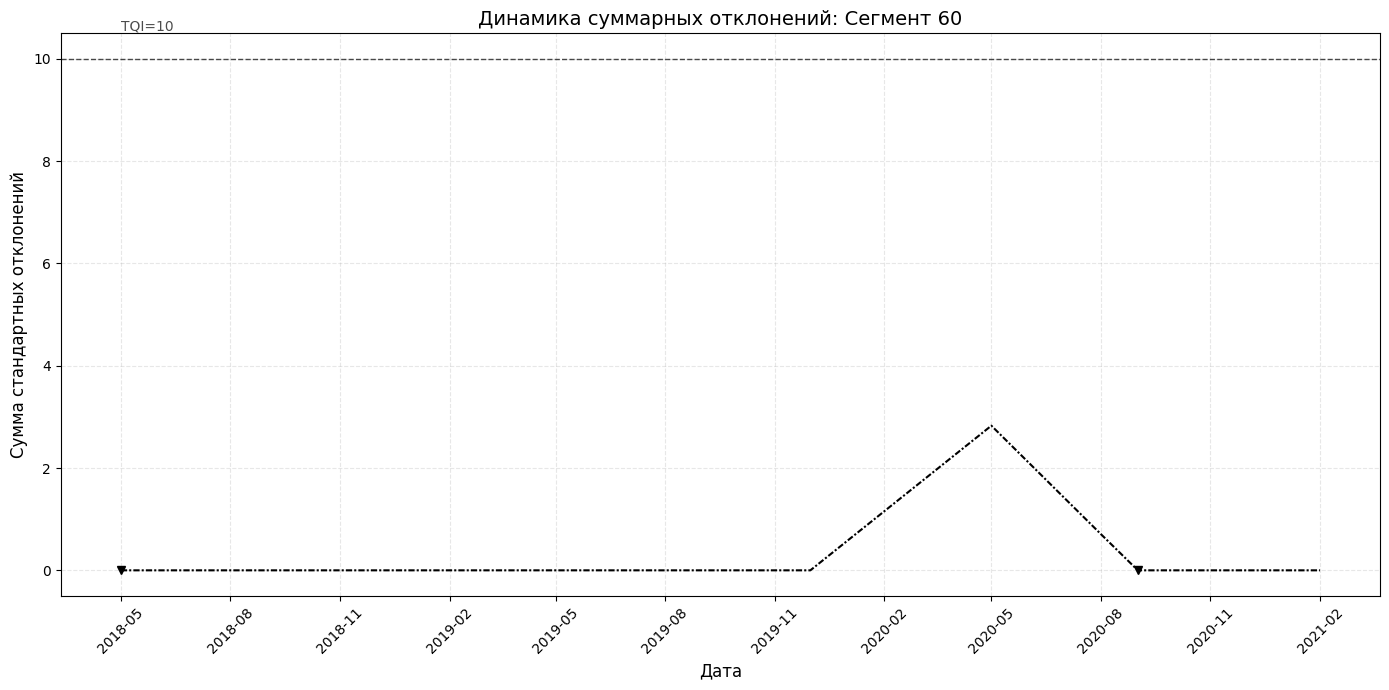

Сегмент 61 пропущен (8 точек)
Сегмент 62 пропущен (10 точек)
Сегмент 63 пропущен (1 точек)
Сегмент 64 пропущен (2 точек)
Сегмент 65 пропущен (1 точек)
Сегмент 66 пропущен (4 точек)
Сегмент 67 пропущен (3 точек)
Сегмент 68 пропущен (1 точек)
Сегмент 69 пропущен (1 точек)
Сегмент 70 пропущен (1 точек)
Сегмент 72 пропущен (1 точек)
Сегмент 73 пропущен (1 точек)
Сегмент 74 пропущен (3 точек)
Сегмент 75 пропущен (8 точек)
Сегмент 76 пропущен (1 точек)
Сегмент 77 пропущен (4 точек)
Сегмент 78 пропущен (5 точек)
Сегмент 79 пропущен (4 точек)


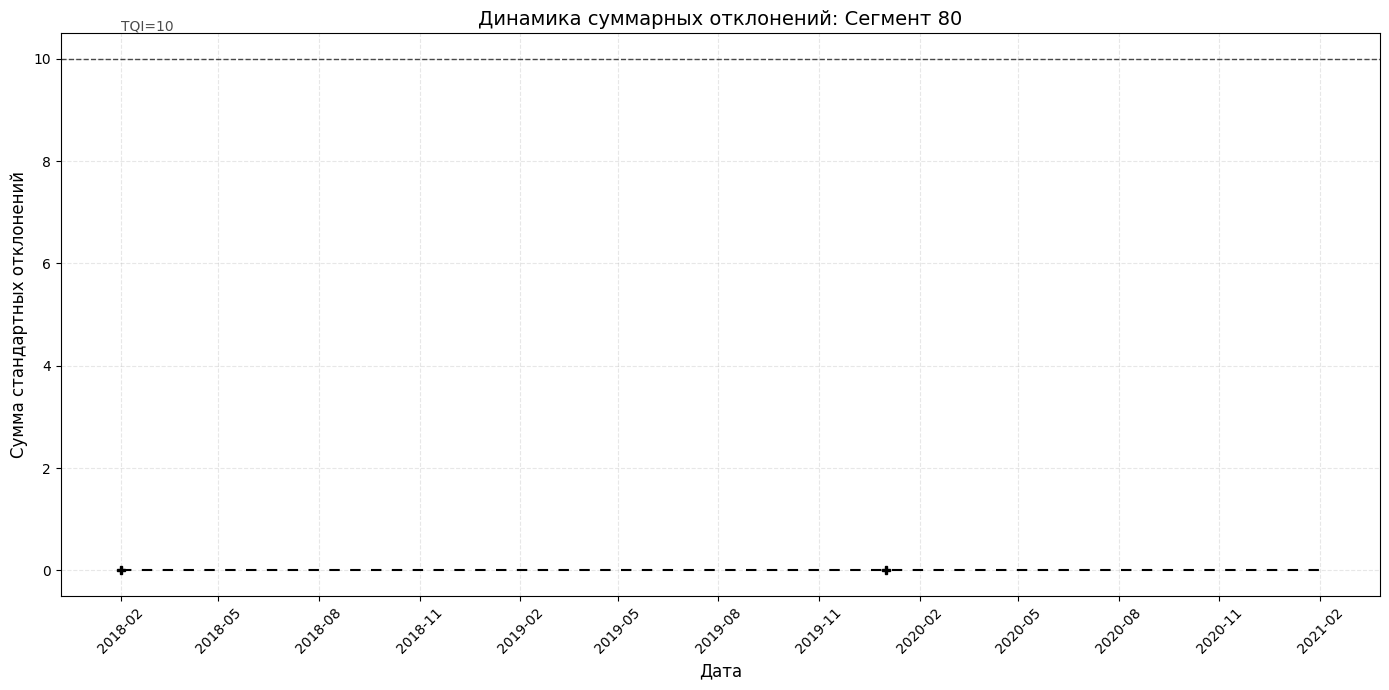

Сегмент 81 пропущен (10 точек)
Сегмент 82 пропущен (5 точек)
Сегмент 84 пропущен (2 точек)
Сегмент 85 пропущен (1 точек)
Сегмент 86 пропущен (6 точек)


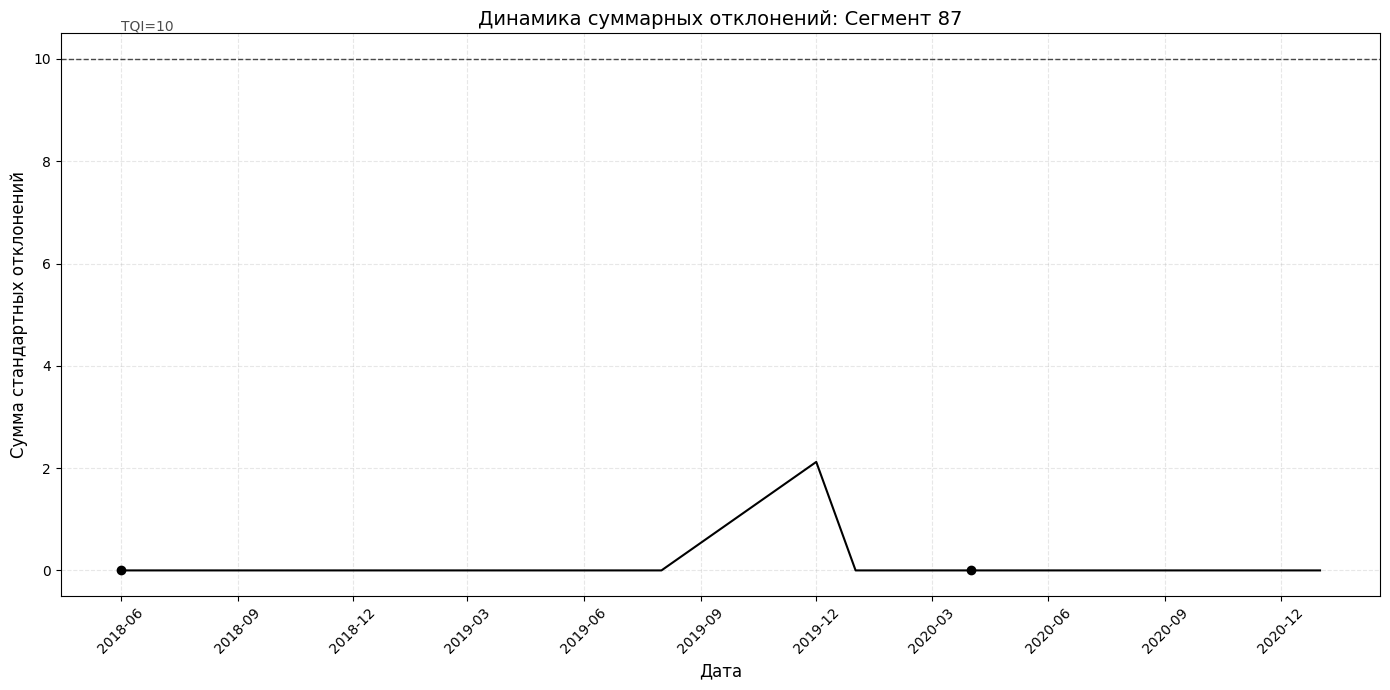

Сегмент 88 пропущен (2 точек)
Сегмент 89 пропущен (5 точек)


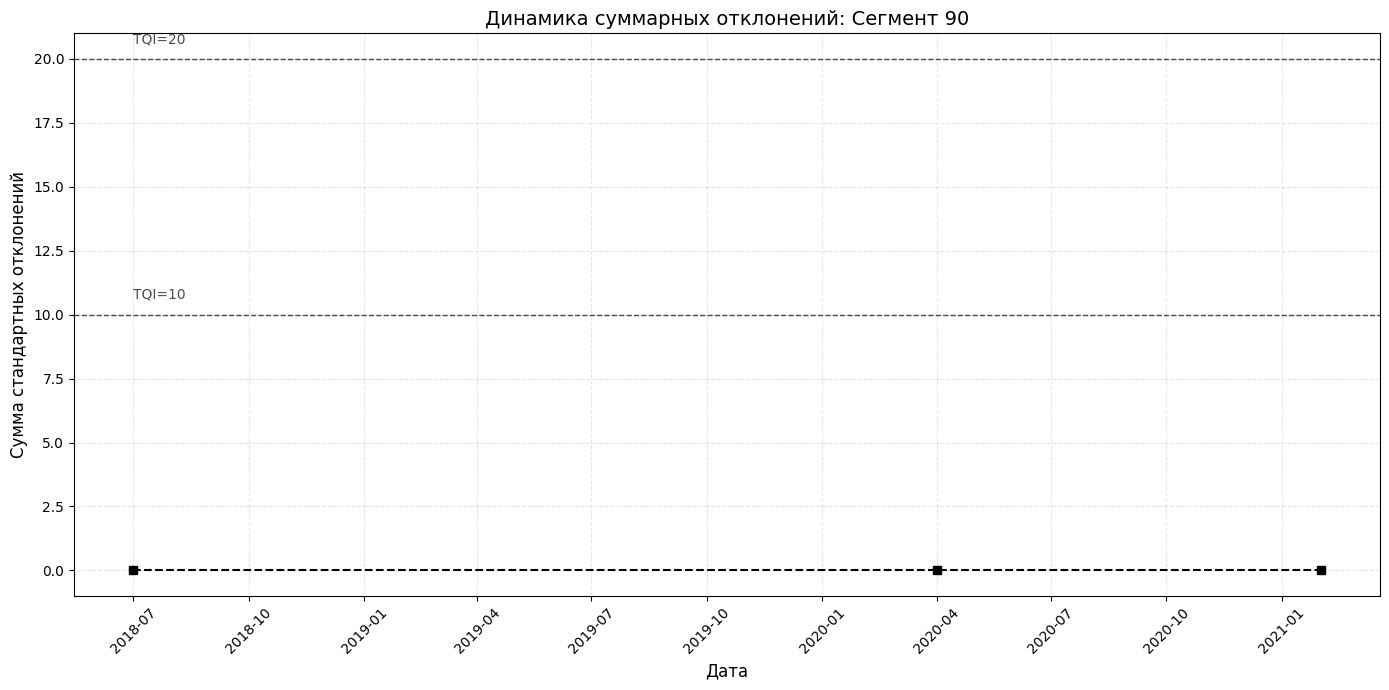

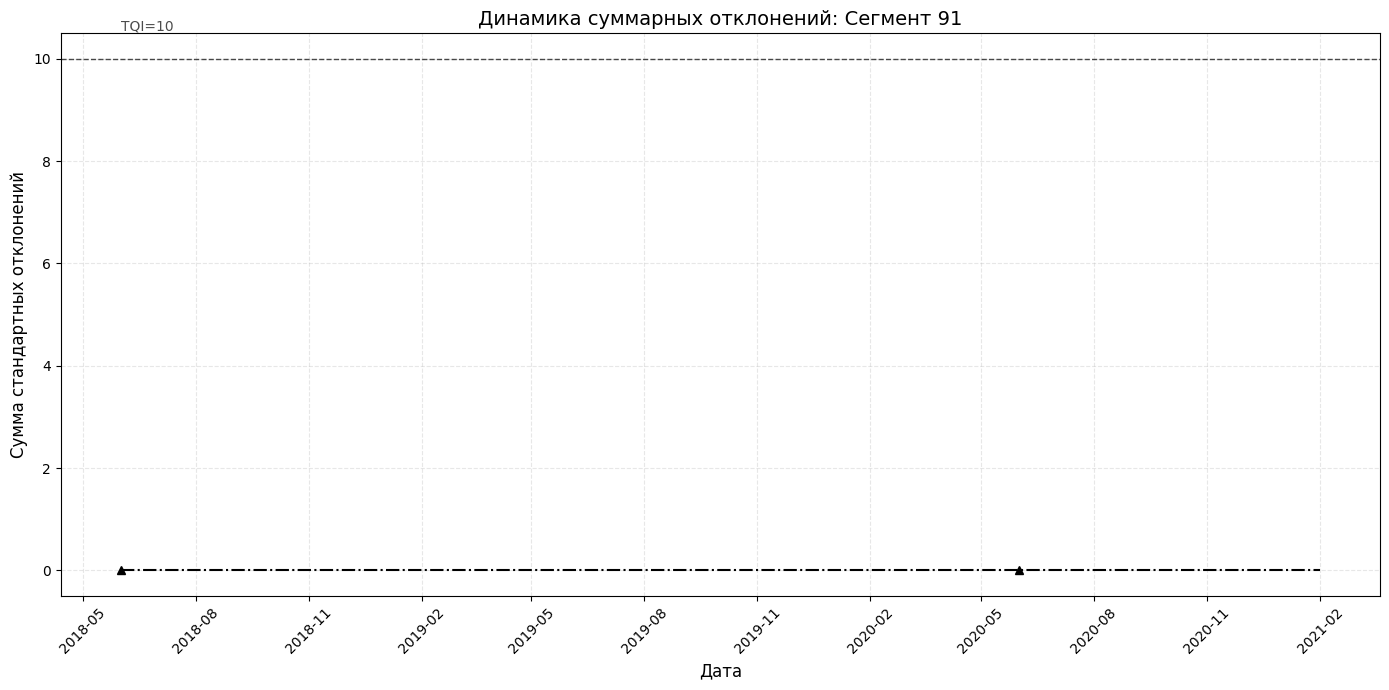

Сегмент 92 пропущен (3 точек)
Сегмент 94 пропущен (1 точек)
Сегмент 95 пропущен (3 точек)
Сегмент 96 пропущен (2 точек)
Сегмент 97 пропущен (3 точек)
Сегмент 98 пропущен (6 точек)
Сегмент 99 пропущен (5 точек)
Сегмент 100 пропущен (1 точек)
Сегмент 101 пропущен (2 точек)
Сегмент 102 пропущен (1 точек)
Сегмент 103 пропущен (2 точек)
Сегмент 105 пропущен (2 точек)
Сегмент 106 пропущен (2 точек)
Сегмент 107 пропущен (9 точек)
Сегмент 108 пропущен (3 точек)
Сегмент 109 пропущен (8 точек)
Сегмент 110 пропущен (3 точек)
Сегмент 111 пропущен (5 точек)
Сегмент 112 пропущен (3 точек)
Сегмент 113 пропущен (1 точек)
Сегмент 115 пропущен (6 точек)
Сегмент 116 пропущен (2 точек)
Сегмент 117 пропущен (1 точек)
Сегмент 118 пропущен (3 точек)
Сегмент 119 пропущен (2 точек)


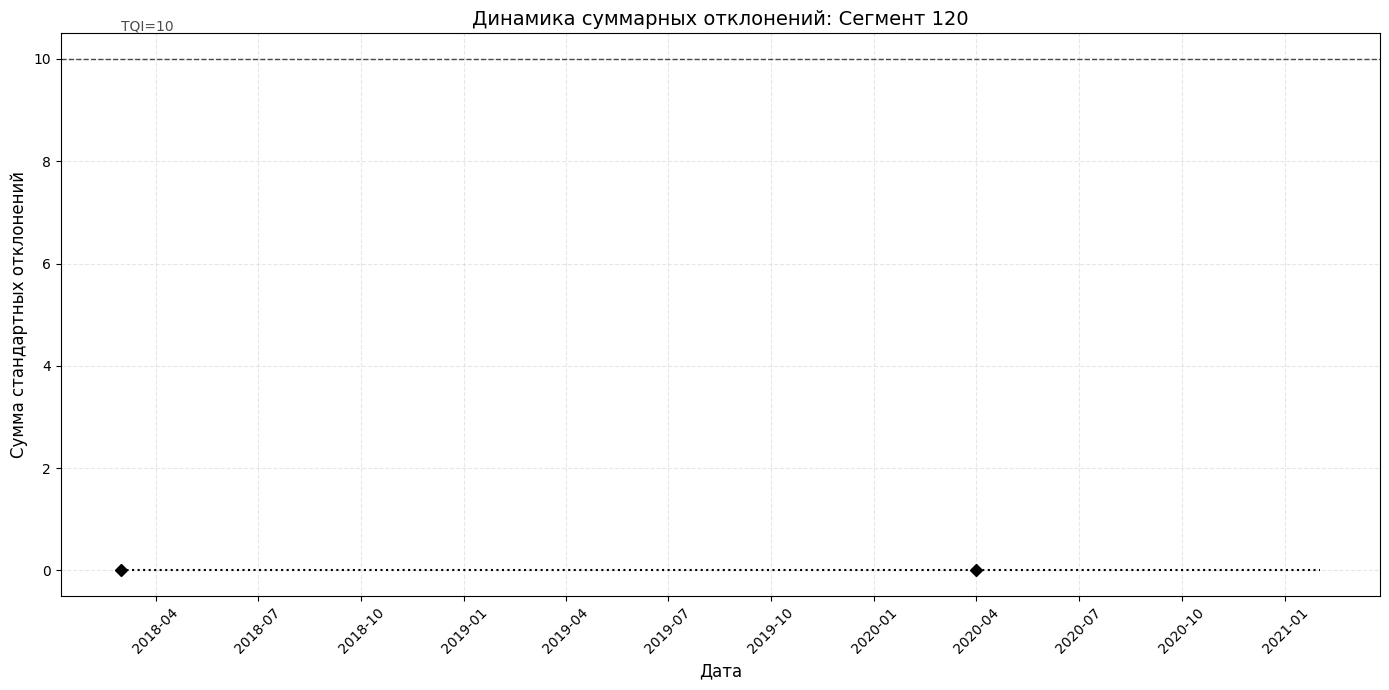

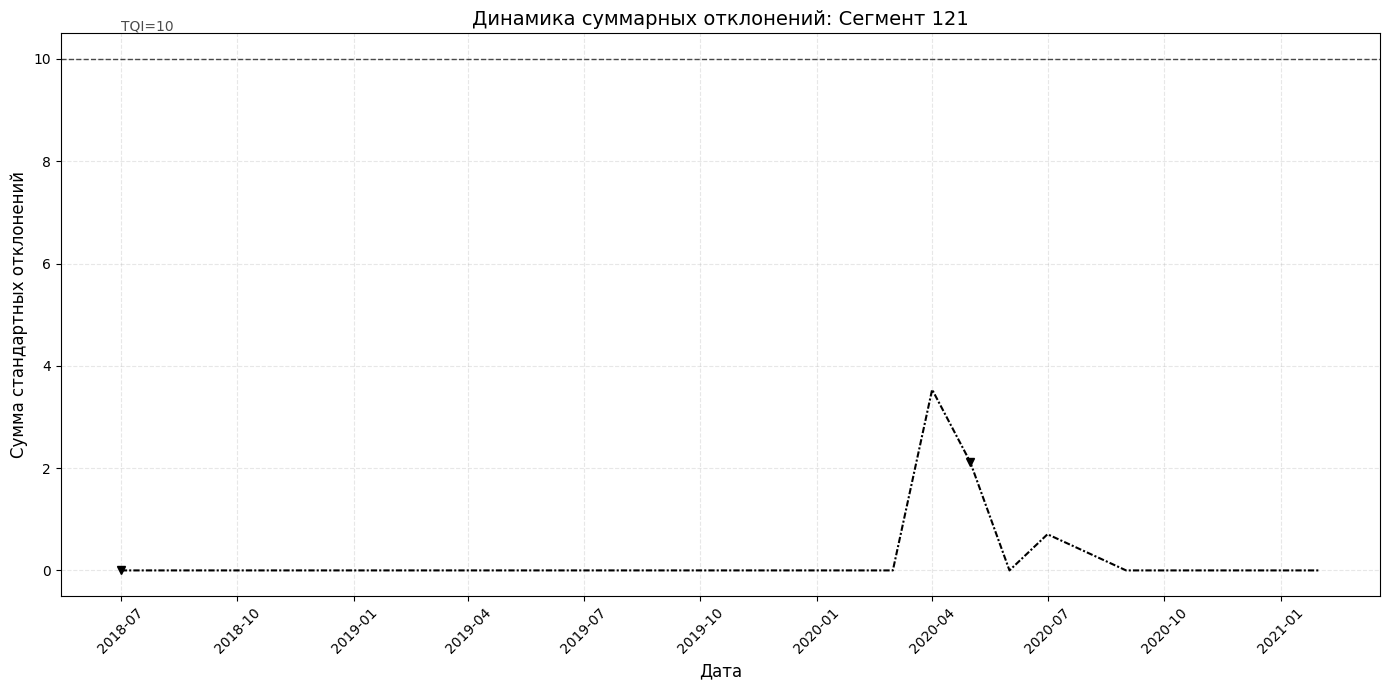

Сегмент 122 пропущен (2 точек)
Сегмент 123 пропущен (10 точек)
Сегмент 124 пропущен (4 точек)
Сегмент 125 пропущен (2 точек)
Сегмент 127 пропущен (1 точек)
Сегмент 128 пропущен (2 точек)


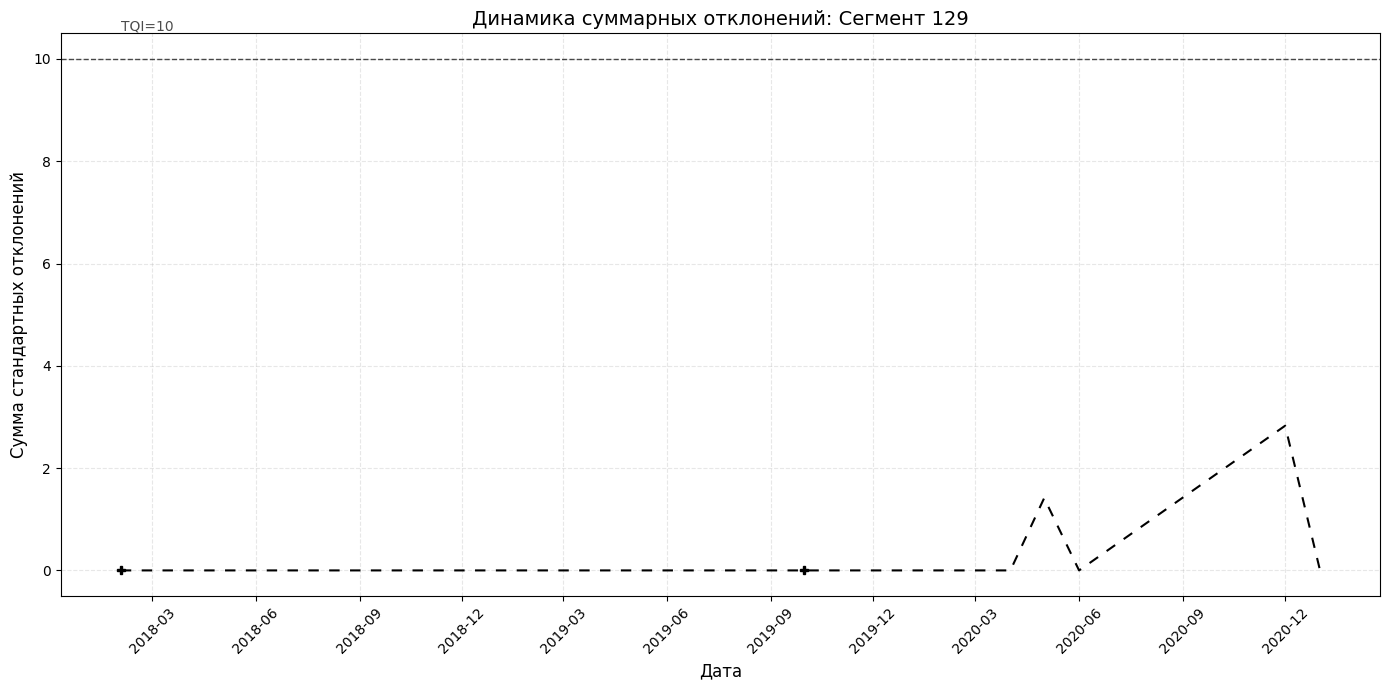

Сегмент 130 пропущен (2 точек)


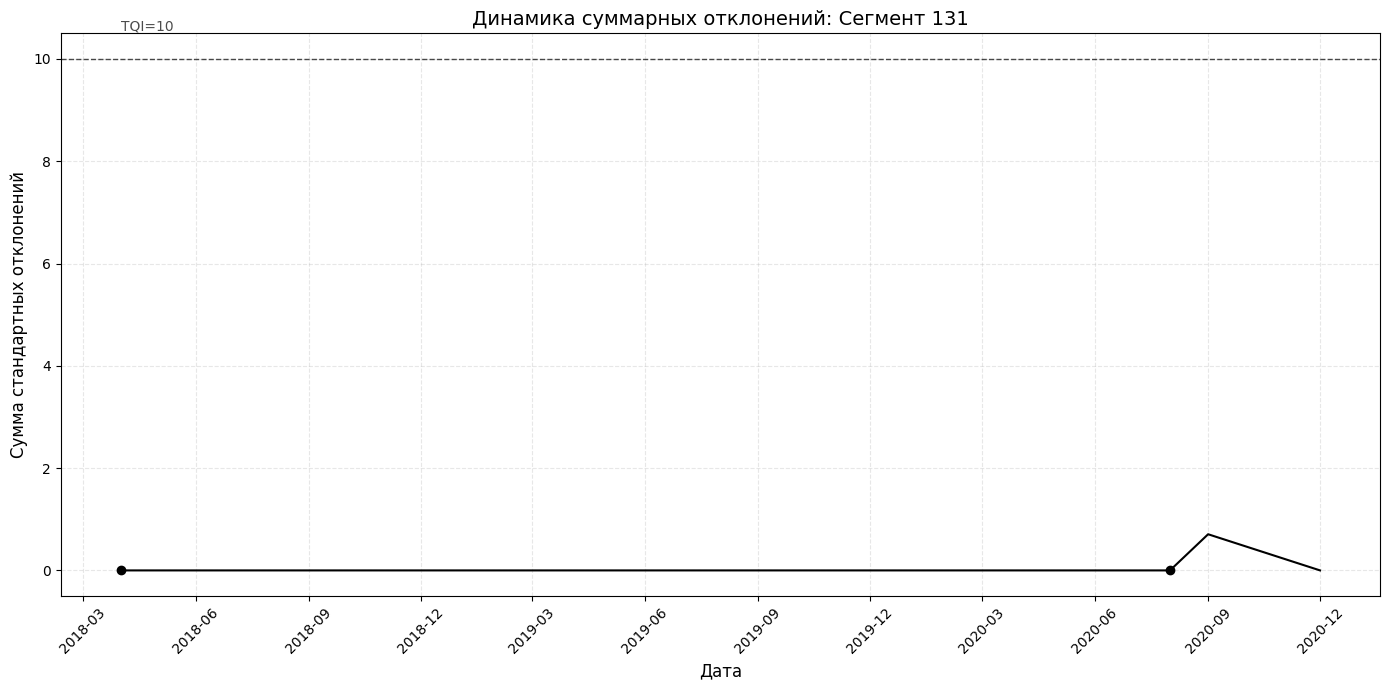

Сегмент 132 пропущен (2 точек)
Сегмент 133 пропущен (7 точек)
Сегмент 134 пропущен (8 точек)
Сегмент 135 пропущен (4 точек)
Сегмент 136 пропущен (2 точек)
Сегмент 139 пропущен (1 точек)
Сегмент 141 пропущен (2 точек)
Сегмент 142 пропущен (1 точек)
Сегмент 143 пропущен (1 точек)
Сегмент 144 пропущен (1 точек)
Сегмент 145 пропущен (1 точек)
Сегмент 146 пропущен (1 точек)
Сегмент 147 пропущен (2 точек)
Сегмент 152 пропущен (1 точек)
Сегмент 158 пропущен (1 точек)
Сегмент 161 пропущен (2 точек)
Сегмент 162 пропущен (2 точек)
Сегмент 164 пропущен (1 точек)
Сегмент 166 пропущен (2 точек)
Сегмент 167 пропущен (1 точек)
Сегмент 168 пропущен (1 точек)
Сегмент 169 пропущен (3 точек)
Сегмент 176 пропущен (4 точек)
Сегмент 177 пропущен (5 точек)
Сегмент 178 пропущен (2 точек)
Сегмент 179 пропущен (2 точек)
Сегмент 180 пропущен (3 точек)
Сегмент 181 пропущен (1 точек)
Сегмент 182 пропущен (1 точек)
Сегмент 185 пропущен (1 точек)
Сегмент 186 пропущен (3 точек)
Сегмент 191 пропущен (1 точек)
Сегмент 

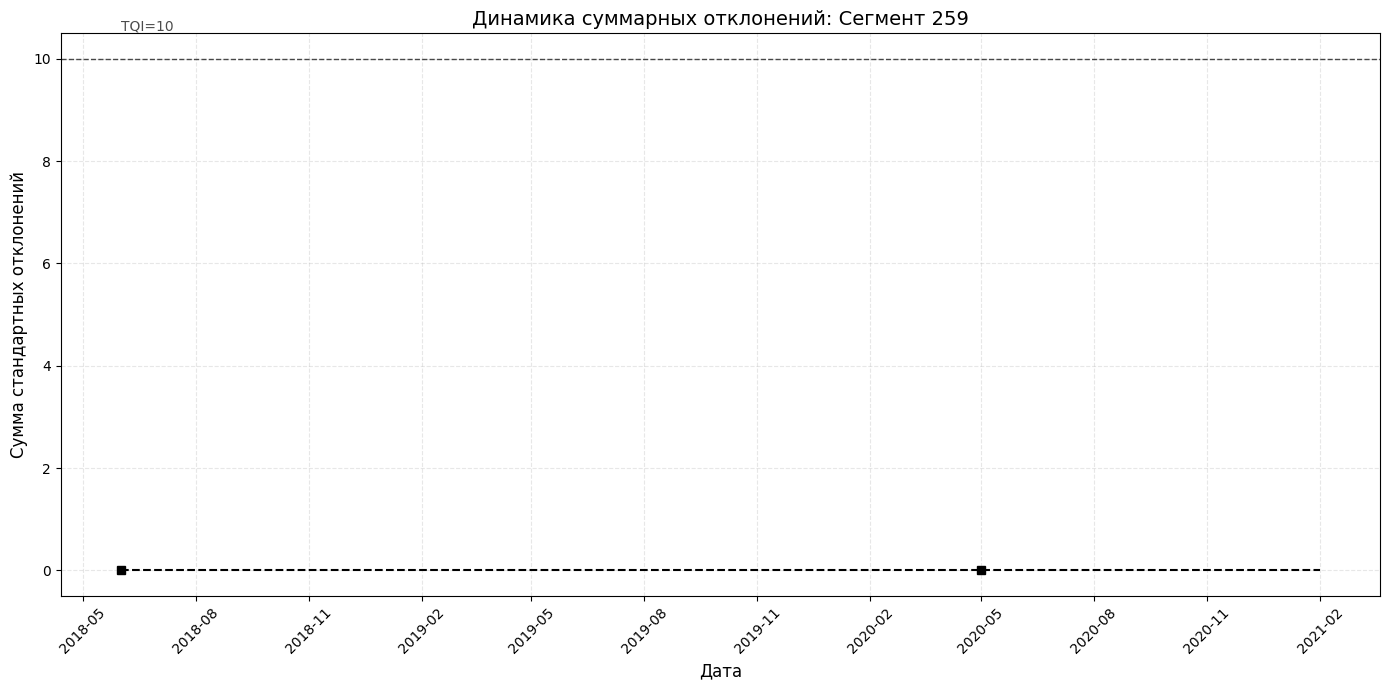

Сегмент 260 пропущен (5 точек)
Сегмент 261 пропущен (5 точек)
Сегмент 265 пропущен (6 точек)
Сегмент 266 пропущен (4 точек)
Сегмент 267 пропущен (4 точек)
Сегмент 268 пропущен (6 точек)
Сегмент 269 пропущен (5 точек)
Сегмент 270 пропущен (9 точек)
Сегмент 271 пропущен (2 точек)
Сегмент 272 пропущен (1 точек)
Сегмент 273 пропущен (3 точек)
Сегмент 274 пропущен (3 точек)
Сегмент 275 пропущен (1 точек)
Сегмент 276 пропущен (1 точек)
Сегмент 277 пропущен (1 точек)
Сегмент 280 пропущен (1 точек)
Сегмент 286 пропущен (2 точек)
Сегмент 287 пропущен (3 точек)
Сегмент 288 пропущен (3 точек)
Сегмент 292 пропущен (1 точек)
Сегмент 294 пропущен (3 точек)
Сегмент 298 пропущен (4 точек)
Сегмент 300 пропущен (1 точек)
Сегмент 303 пропущен (1 точек)
Сегмент 306 пропущен (1 точек)
Сегмент 312 пропущен (1 точек)
Сегмент 313 пропущен (1 точек)
Сегмент 314 пропущен (1 точек)
Сегмент 315 пропущен (1 точек)
Сегмент 316 пропущен (1 точек)
Сегмент 317 пропущен (2 точек)
Сегмент 318 пропущен (3 точек)
Сегмент 

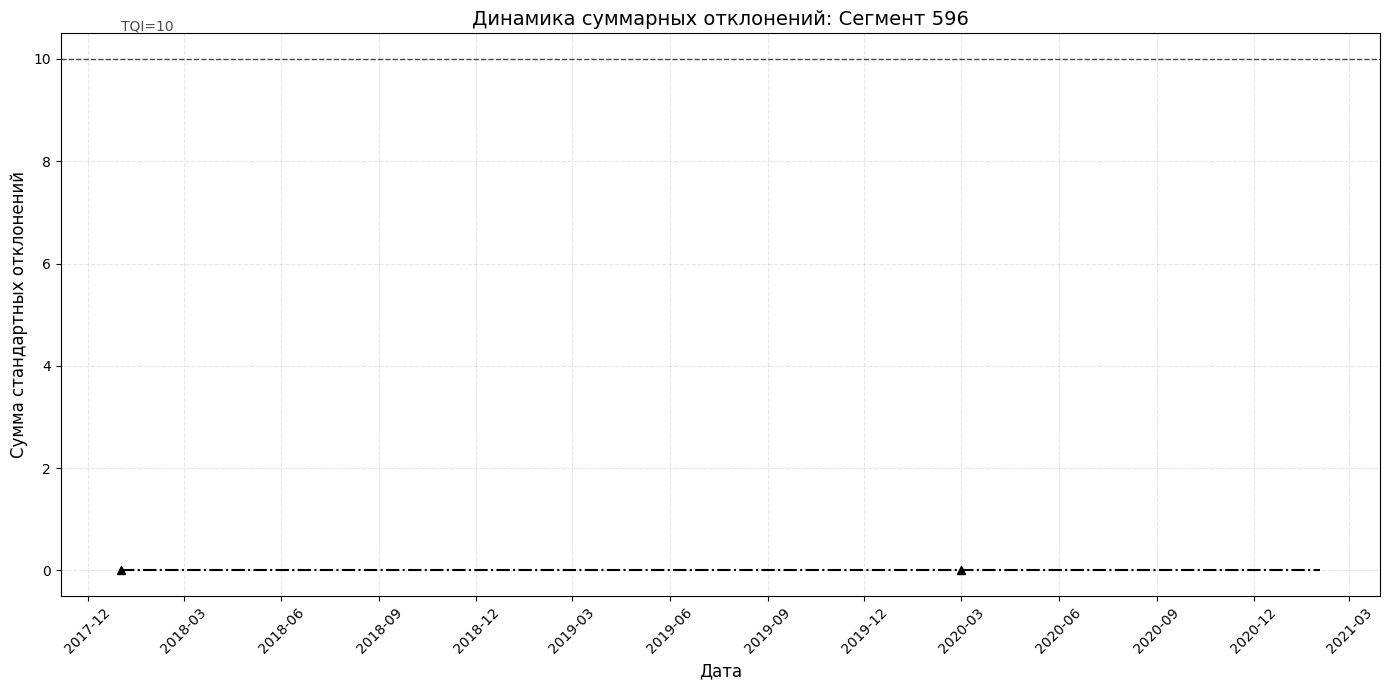

Сегмент 597 пропущен (7 точек)
Сегмент 598 пропущен (3 точек)
Сегмент 599 пропущен (4 точек)
Сегмент 600 пропущен (1 точек)
Сегмент 601 пропущен (2 точек)
Сегмент 607 пропущен (1 точек)
Сегмент 608 пропущен (1 точек)
Сегмент 611 пропущен (4 точек)
Сегмент 613 пропущен (2 точек)
Сегмент 615 пропущен (2 точек)
Сегмент 617 пропущен (1 точек)
Сегмент 618 пропущен (3 точек)
Сегмент 620 пропущен (1 точек)
Сегмент 621 пропущен (1 точек)
Сегмент 625 пропущен (5 точек)
Сегмент 628 пропущен (1 точек)
Сегмент 629 пропущен (3 точек)
Сегмент 632 пропущен (1 точек)
Сегмент 633 пропущен (3 точек)
Сегмент 634 пропущен (3 точек)
Сегмент 635 пропущен (2 точек)
Сегмент 641 пропущен (1 точек)
Сегмент 647 пропущен (1 точек)
Сегмент 650 пропущен (1 точек)
Сегмент 654 пропущен (3 точек)
Сегмент 655 пропущен (1 точек)
Сегмент 658 пропущен (1 точек)
Сегмент 667 пропущен (2 точек)
Сегмент 669 пропущен (1 точек)
Сегмент 670 пропущен (2 точек)
Сегмент 671 пропущен (2 точек)
Сегмент 673 пропущен (2 точек)
Сегмент 

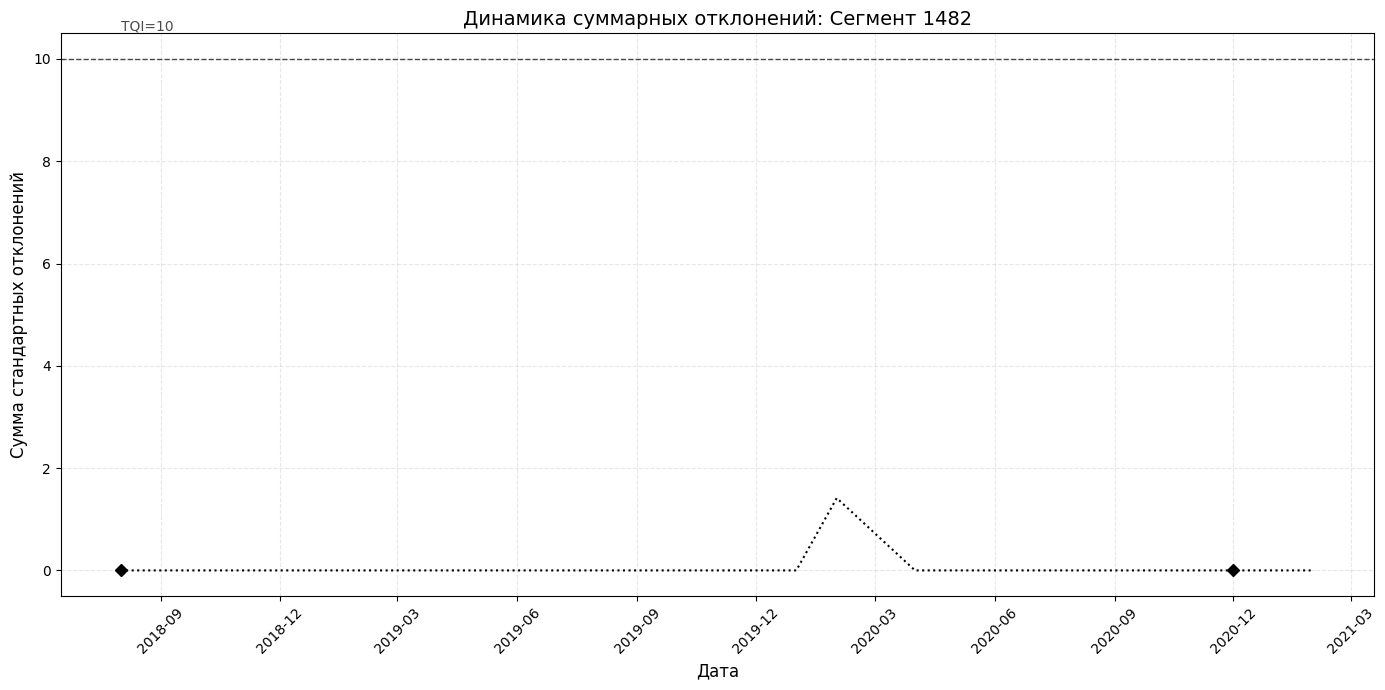

Сегмент 1483 пропущен (1 точек)
Сегмент 1484 пропущен (2 точек)
Сегмент 1485 пропущен (1 точек)
Сегмент 1486 пропущен (2 точек)
Сегмент 1489 пропущен (3 точек)
Сегмент 1490 пропущен (1 точек)
Сегмент 1491 пропущен (5 точек)
Сегмент 1492 пропущен (2 точек)
Сегмент 1493 пропущен (3 точек)
Сегмент 1494 пропущен (1 точек)
Сегмент 1496 пропущен (1 точек)
Сегмент 1500 пропущен (1 точек)
Сегмент 1502 пропущен (1 точек)
Сегмент 1504 пропущен (1 точек)
Сегмент 1506 пропущен (1 точек)
Сегмент 1507 пропущен (1 точек)
Сегмент 1508 пропущен (1 точек)
Сегмент 1509 пропущен (1 точек)
Сегмент 1510 пропущен (1 точек)
Сегмент 1512 пропущен (4 точек)
Сегмент 1513 пропущен (2 точек)
Сегмент 1514 пропущен (2 точек)
Сегмент 1515 пропущен (2 точек)
Сегмент 1516 пропущен (1 точек)
Сегмент 1517 пропущен (1 точек)
Сегмент 1520 пропущен (1 точек)
Сегмент 1521 пропущен (1 точек)
Сегмент 1525 пропущен (1 точек)
Сегмент 1528 пропущен (1 точек)
Сегмент 1530 пропущен (5 точек)
Сегмент 1531 пропущен (5 точек)
Сегмент 

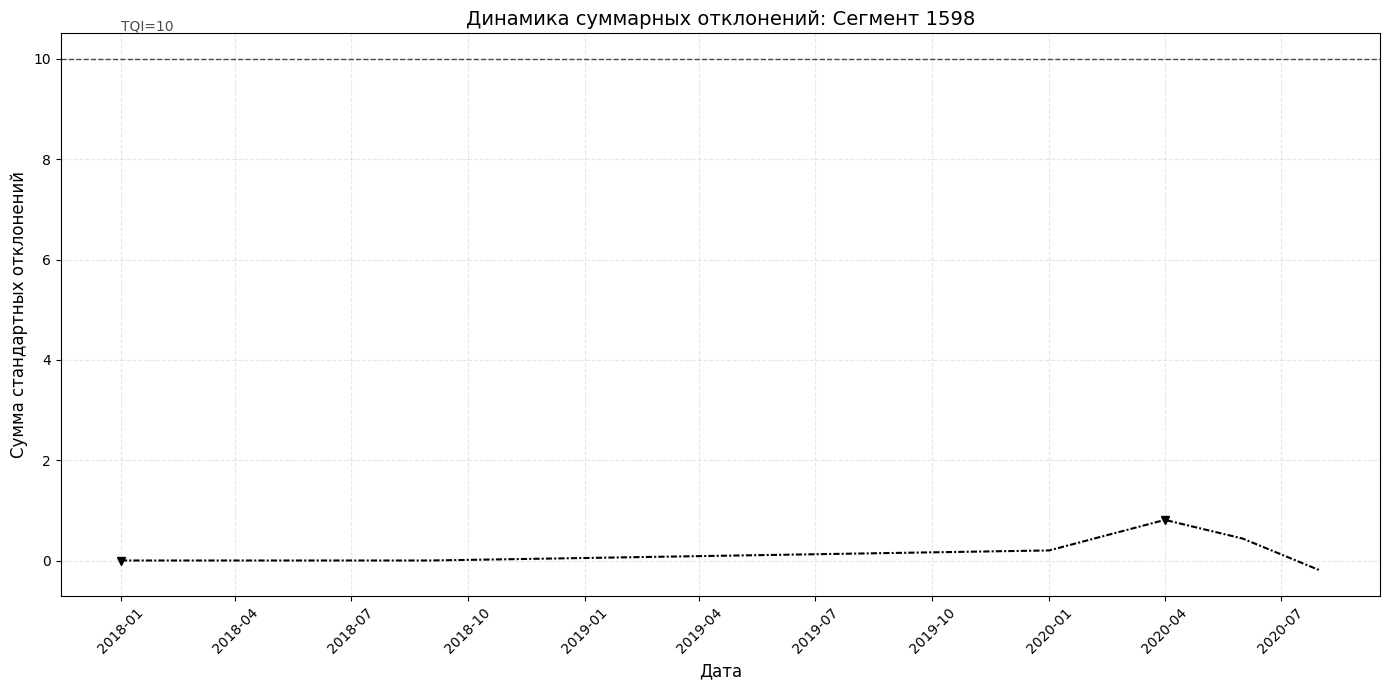

Сегмент 1599 пропущен (4 точек)
Сегмент 1600 пропущен (10 точек)
Сегмент 1602 пропущен (2 точек)
Сегмент 1603 пропущен (5 точек)
Сегмент 1604 пропущен (9 точек)
Сегмент 1608 пропущен (2 точек)
Сегмент 1609 пропущен (1 точек)
Сегмент 1611 пропущен (4 точек)
Сегмент 1612 пропущен (9 точек)
Сегмент 1613 пропущен (3 точек)
Сегмент 1614 пропущен (1 точек)
Сегмент 1615 пропущен (8 точек)
Сегмент 1616 пропущен (2 точек)
Сегмент 1617 пропущен (1 точек)
Сегмент 1618 пропущен (1 точек)
Сегмент 1619 пропущен (2 точек)
Сегмент 1620 пропущен (3 точек)
Сегмент 1622 пропущен (1 точек)
Сегмент 1624 пропущен (1 точек)
Сегмент 1628 пропущен (1 точек)
Сегмент 1629 пропущен (1 точек)
Сегмент 1630 пропущен (2 точек)
Сегмент 1631 пропущен (3 точек)
Сегмент 1633 пропущен (1 точек)
Сегмент 1635 пропущен (1 точек)
Сегмент 1636 пропущен (2 точек)
Сегмент 1638 пропущен (1 точек)
Сегмент 1639 пропущен (4 точек)
Сегмент 1641 пропущен (3 точек)
Сегмент 1647 пропущен (1 точек)
Сегмент 1650 пропущен (3 точек)
Сегмент

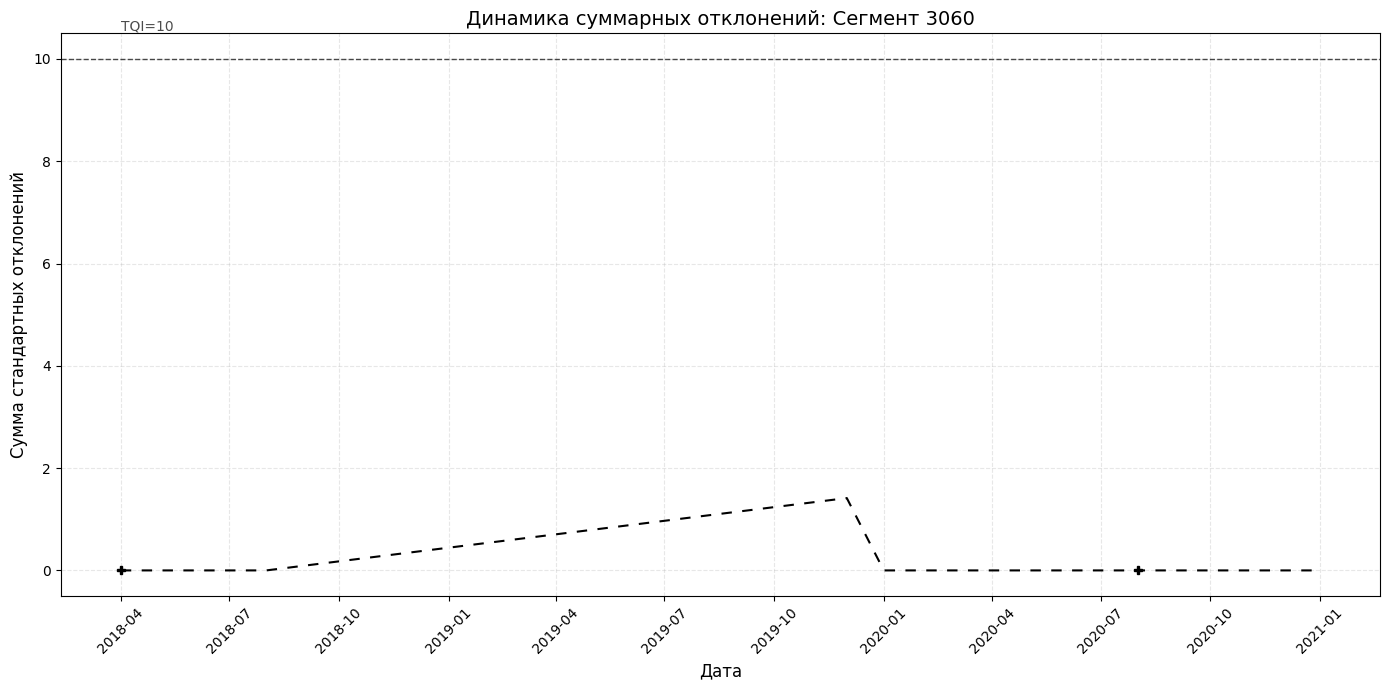

Сегмент 3061 пропущен (3 точек)


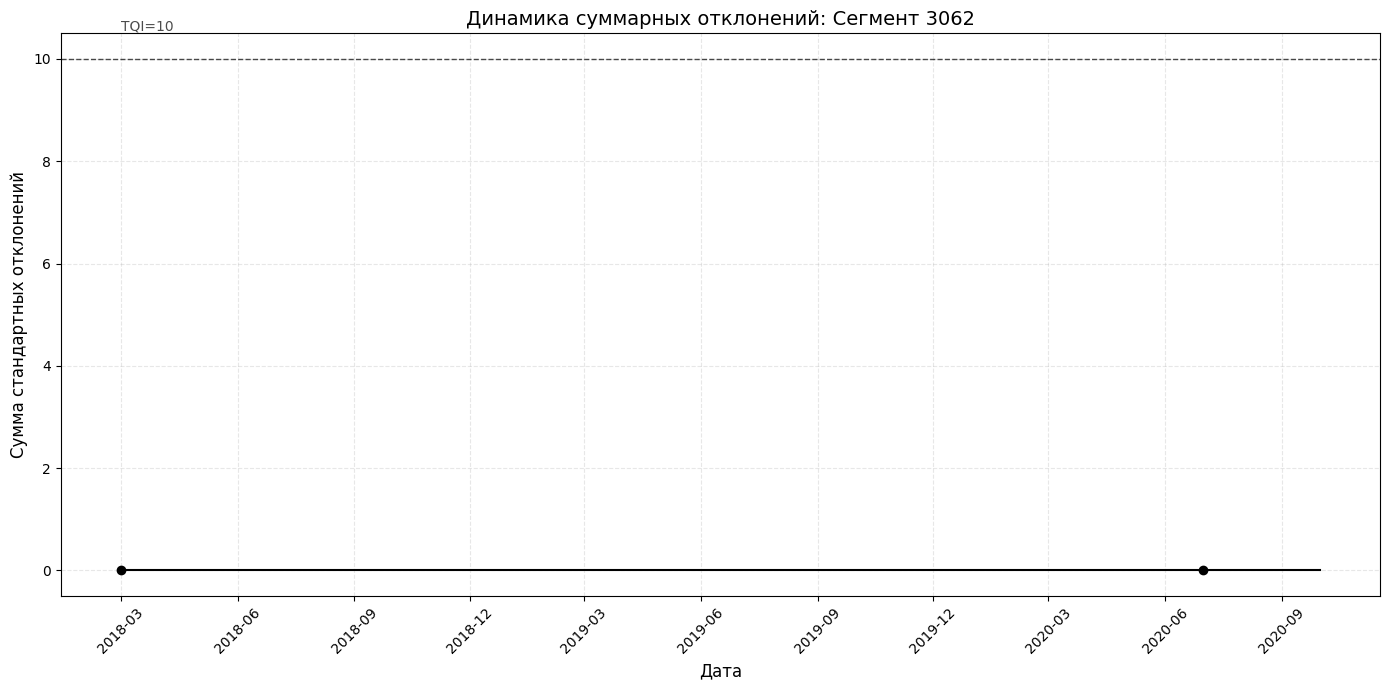

Сегмент 3063 пропущен (5 точек)
Сегмент 3064 пропущен (3 точек)
Сегмент 3065 пропущен (5 точек)
Сегмент 3066 пропущен (2 точек)
Сегмент 3067 пропущен (7 точек)
Сегмент 3068 пропущен (7 точек)
Сегмент 3069 пропущен (7 точек)
Сегмент 3070 пропущен (10 точек)
Сегмент 3071 пропущен (2 точек)
Сегмент 3072 пропущен (5 точек)
Сегмент 3073 пропущен (2 точек)
Сегмент 3074 пропущен (1 точек)
Сегмент 3077 пропущен (2 точек)
Сегмент 3078 пропущен (2 точек)
Сегмент 3079 пропущен (1 точек)
Сегмент 3080 пропущен (2 точек)
Сегмент 3081 пропущен (3 точек)
Сегмент 3082 пропущен (1 точек)
Сегмент 3084 пропущен (2 точек)
Сегмент 3085 пропущен (2 точек)
Сегмент 3086 пропущен (4 точек)
Сегмент 3087 пропущен (5 точек)
Сегмент 3088 пропущен (3 точек)
Сегмент 3089 пропущен (1 точек)
Сегмент 3090 пропущен (3 точек)
Сегмент 3091 пропущен (1 точек)
Сегмент 3092 пропущен (5 точек)
Сегмент 3093 пропущен (8 точек)
Сегмент 3094 пропущен (5 точек)
Сегмент 3095 пропущен (6 точек)
Сегмент 3097 пропущен (1 точек)
Сегмент

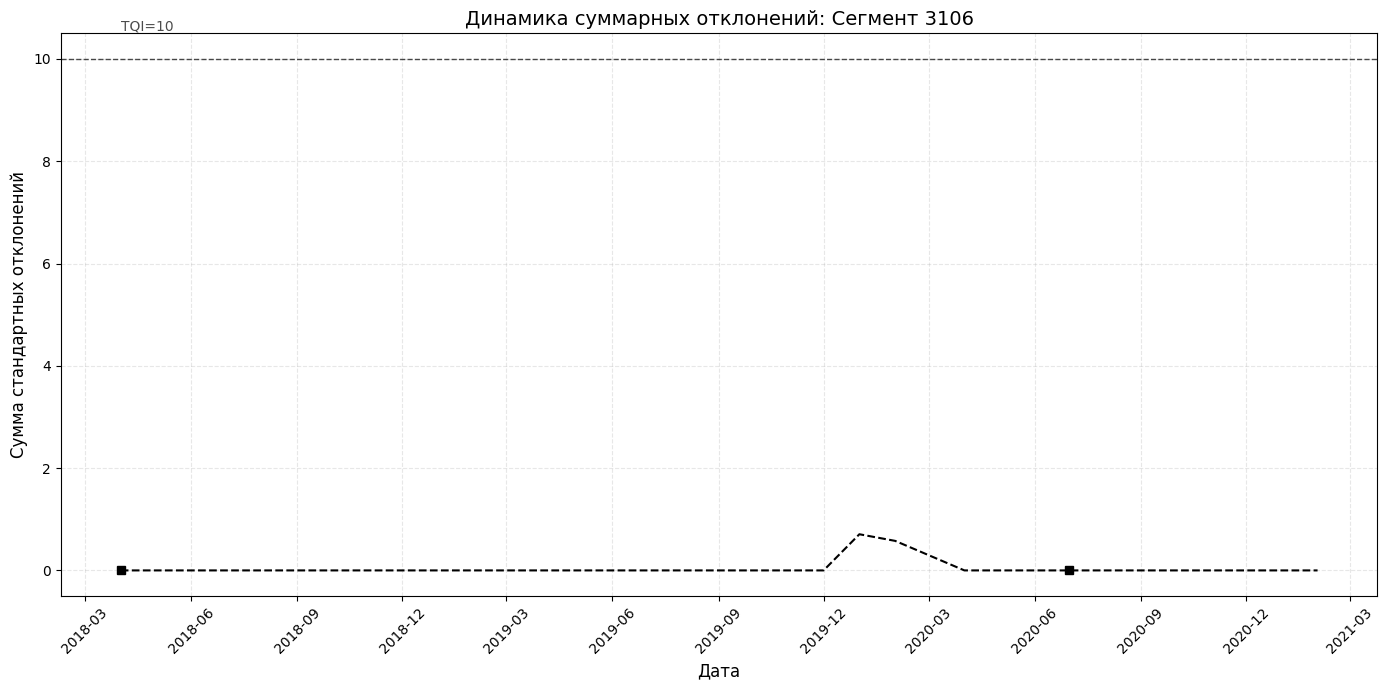

Сегмент 3107 пропущен (3 точек)
Сегмент 3108 пропущен (3 точек)
Сегмент 3109 пропущен (8 точек)


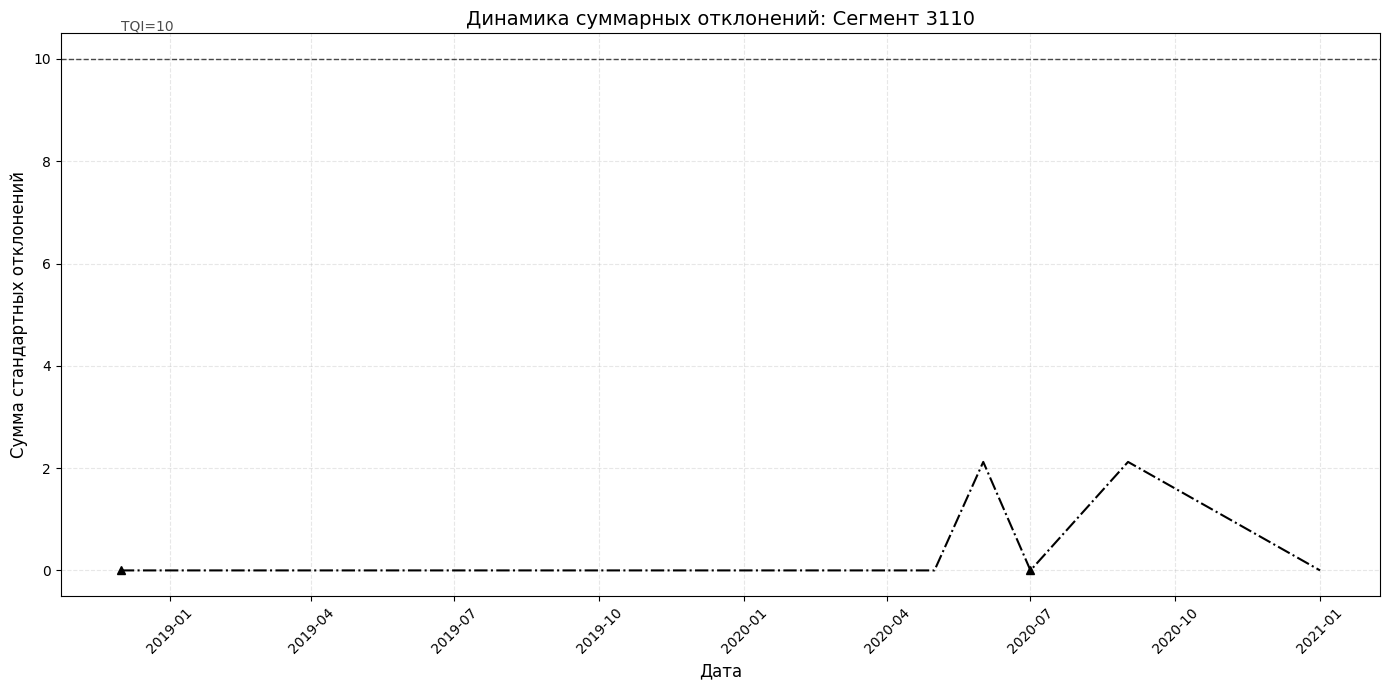

Сегмент 3112 пропущен (4 точек)
Сегмент 3113 пропущен (4 точек)
Сегмент 3115 пропущен (3 точек)
Сегмент 3117 пропущен (3 точек)
Сегмент 3118 пропущен (1 точек)
Сегмент 3119 пропущен (4 точек)
Сегмент 3121 пропущен (4 точек)
Сегмент 3122 пропущен (5 точек)
Сегмент 3123 пропущен (5 точек)
Сегмент 3124 пропущен (3 точек)
Сегмент 3126 пропущен (1 точек)
Сегмент 3127 пропущен (3 точек)
Сегмент 3128 пропущен (7 точек)
Сегмент 3129 пропущен (4 точек)
Сегмент 3130 пропущен (1 точек)
Сегмент 3133 пропущен (1 точек)
Сегмент 3134 пропущен (2 точек)
Сегмент 3135 пропущен (1 точек)
Сегмент 3136 пропущен (4 точек)
Сегмент 3137 пропущен (2 точек)
Сегмент 3138 пропущен (2 точек)
Сегмент 3139 пропущен (6 точек)
Сегмент 3140 пропущен (3 точек)
Сегмент 3141 пропущен (1 точек)
Сегмент 3143 пропущен (1 точек)
Сегмент 3145 пропущен (1 точек)
Сегмент 3146 пропущен (1 точек)
Сегмент 3147 пропущен (2 точек)
Сегмент 3148 пропущен (3 точек)
Сегмент 3149 пропущен (1 точек)
Сегмент 3150 пропущен (10 точек)
Сегмент

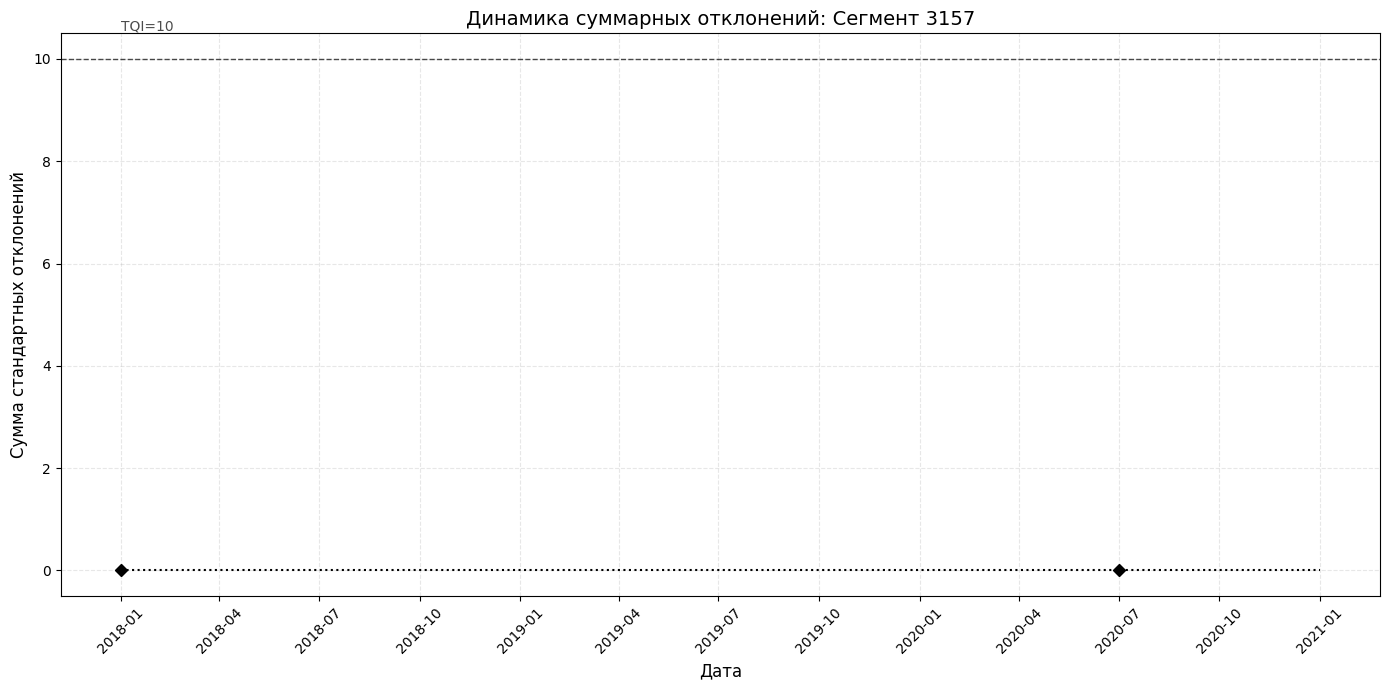

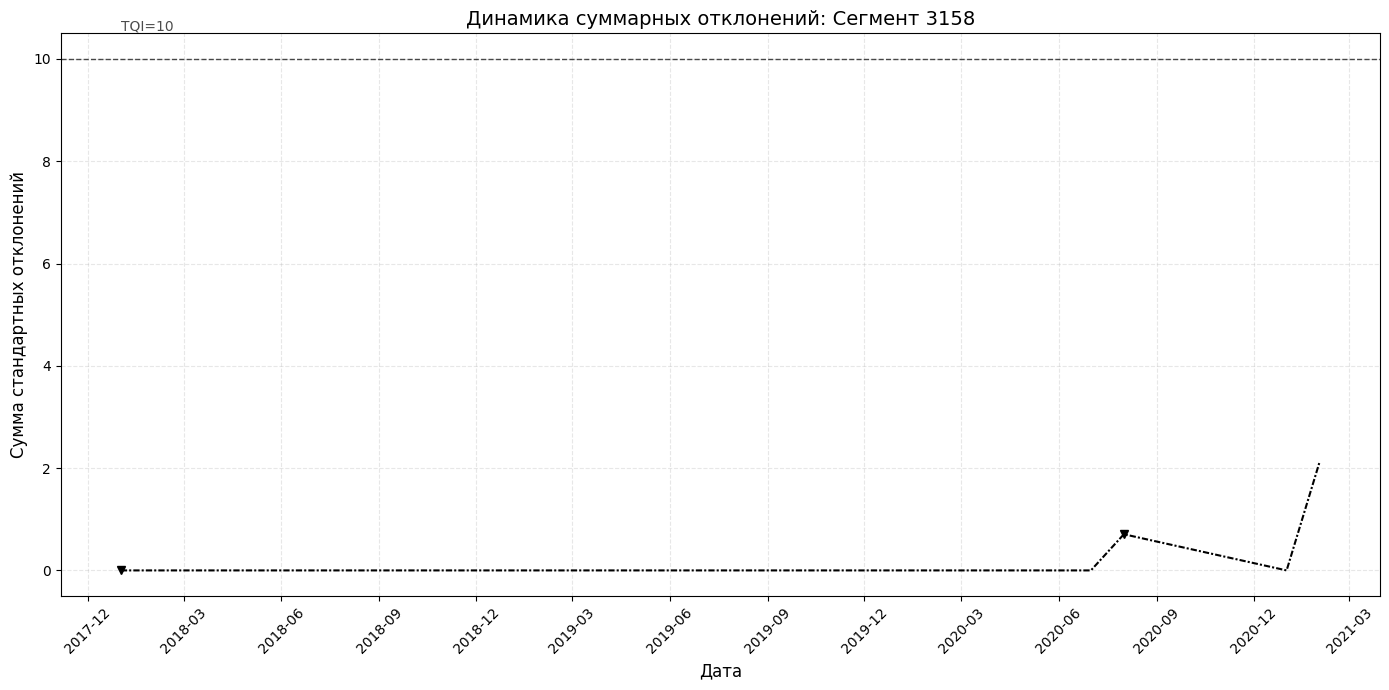

Сегмент 3159 пропущен (8 точек)
Сегмент 3160 пропущен (8 точек)
Сегмент 3161 пропущен (4 точек)
Сегмент 3162 пропущен (5 точек)
Сегмент 3163 пропущен (7 точек)
Сегмент 3164 пропущен (3 точек)
Сегмент 3165 пропущен (1 точек)
Сегмент 3166 пропущен (4 точек)
Сегмент 3167 пропущен (1 точек)
Сегмент 3168 пропущен (2 точек)
Сегмент 3169 пропущен (5 точек)
Сегмент 3170 пропущен (1 точек)
Сегмент 3172 пропущен (1 точек)
Сегмент 3174 пропущен (4 точек)
Сегмент 3175 пропущен (2 точек)
Сегмент 3176 пропущен (9 точек)
Сегмент 3177 пропущен (5 точек)
Сегмент 3178 пропущен (7 точек)
Сегмент 3179 пропущен (6 точек)
Сегмент 3180 пропущен (5 точек)
Сегмент 3181 пропущен (10 точек)
Сегмент 3182 пропущен (6 точек)
Сегмент 3183 пропущен (6 точек)
Сегмент 3184 пропущен (6 точек)
Сегмент 3185 пропущен (10 точек)
Сегмент 3186 пропущен (4 точек)
Сегмент 3187 пропущен (2 точек)
Сегмент 3188 пропущен (10 точек)
Сегмент 3189 пропущен (9 точек)
Сегмент 3190 пропущен (3 точек)
Сегмент 3191 пропущен (3 точек)
Сегме

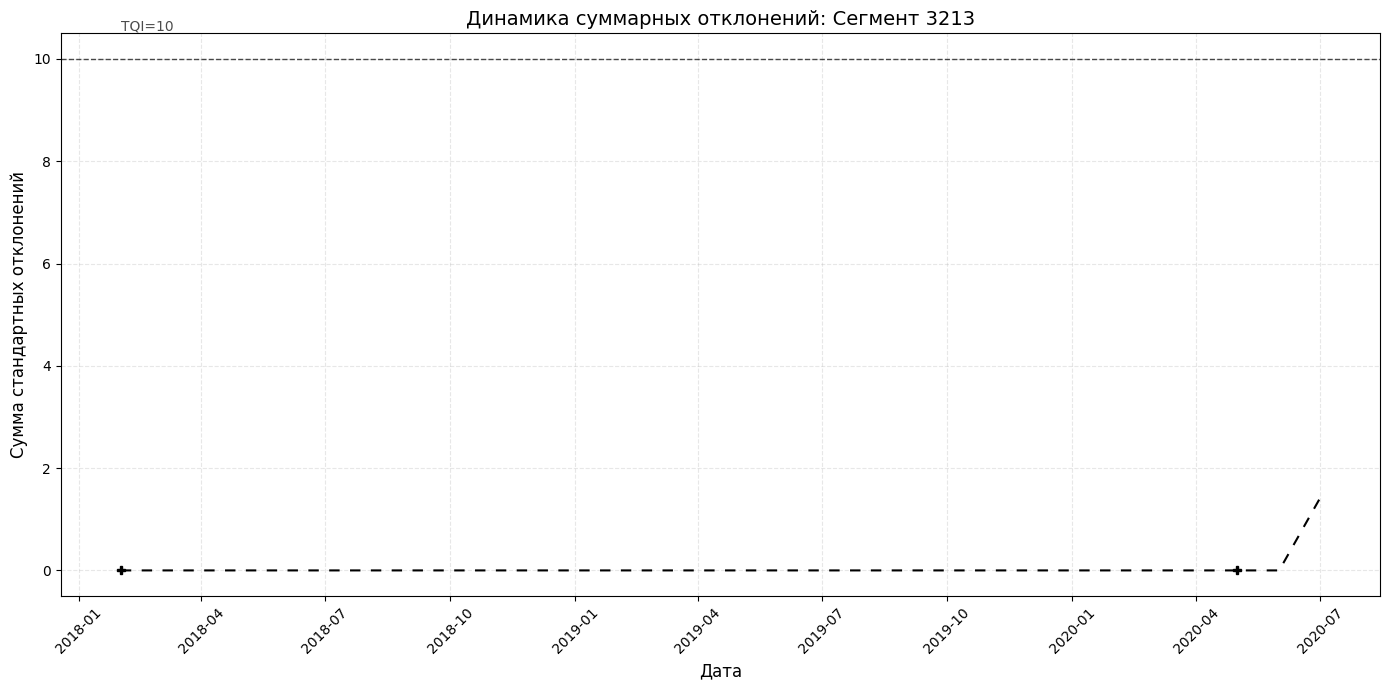

Сегмент 3214 пропущен (10 точек)
Сегмент 3216 пропущен (5 точек)
Сегмент 3217 пропущен (1 точек)
Сегмент 3218 пропущен (5 точек)
Сегмент 3219 пропущен (1 точек)
Сегмент 3220 пропущен (2 точек)
Сегмент 3223 пропущен (1 точек)
Сегмент 3224 пропущен (3 точек)
Сегмент 3225 пропущен (6 точек)
Сегмент 3226 пропущен (10 точек)


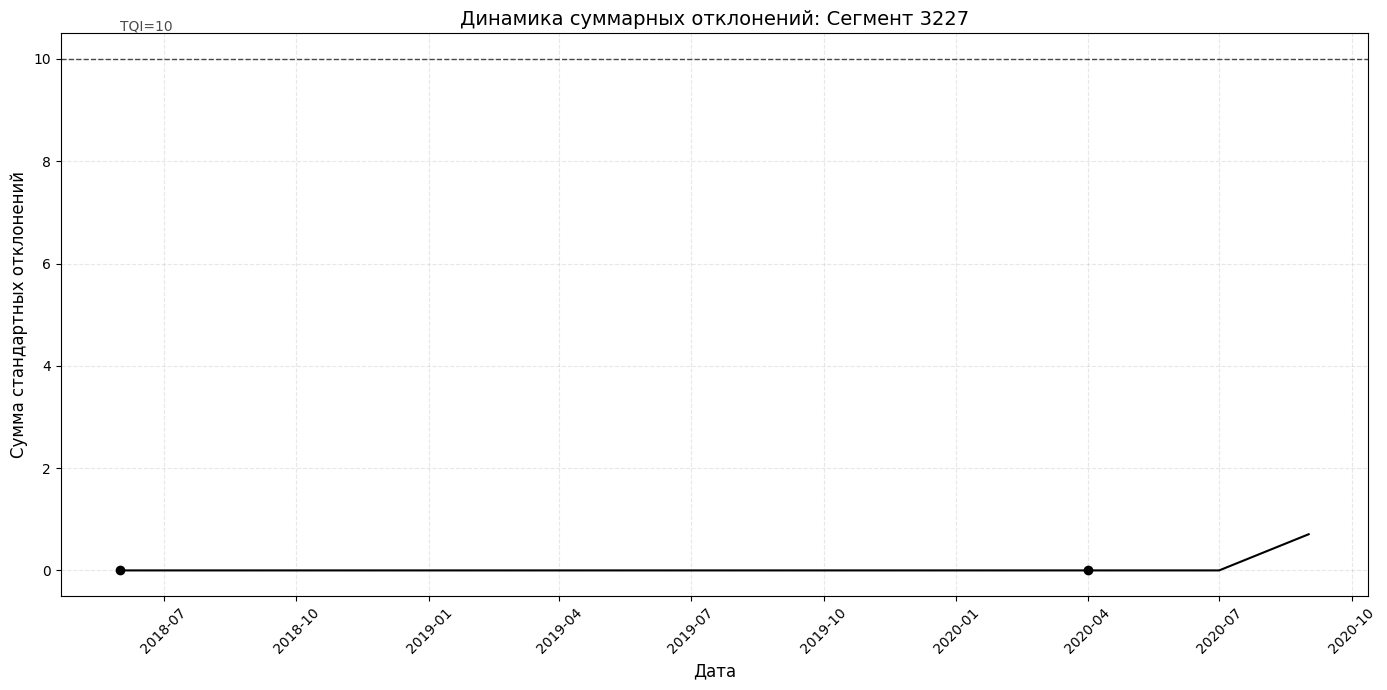

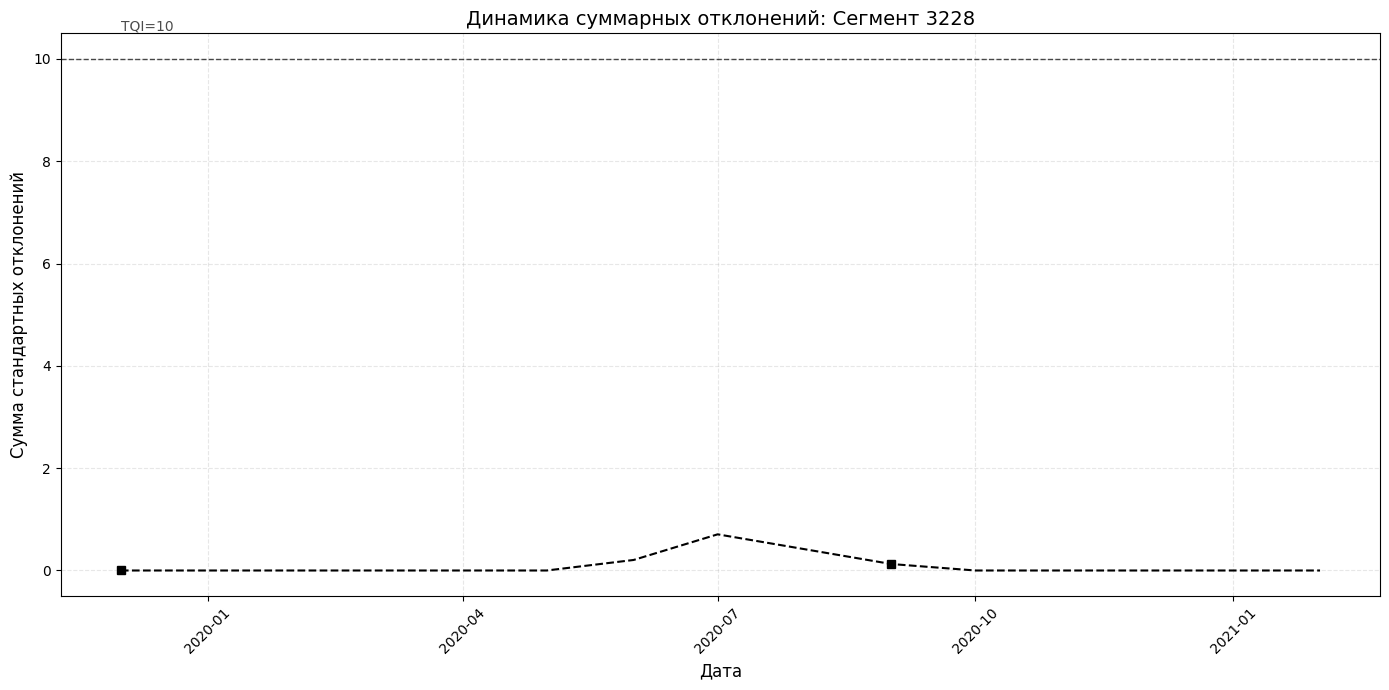

Сегмент 3229 пропущен (5 точек)


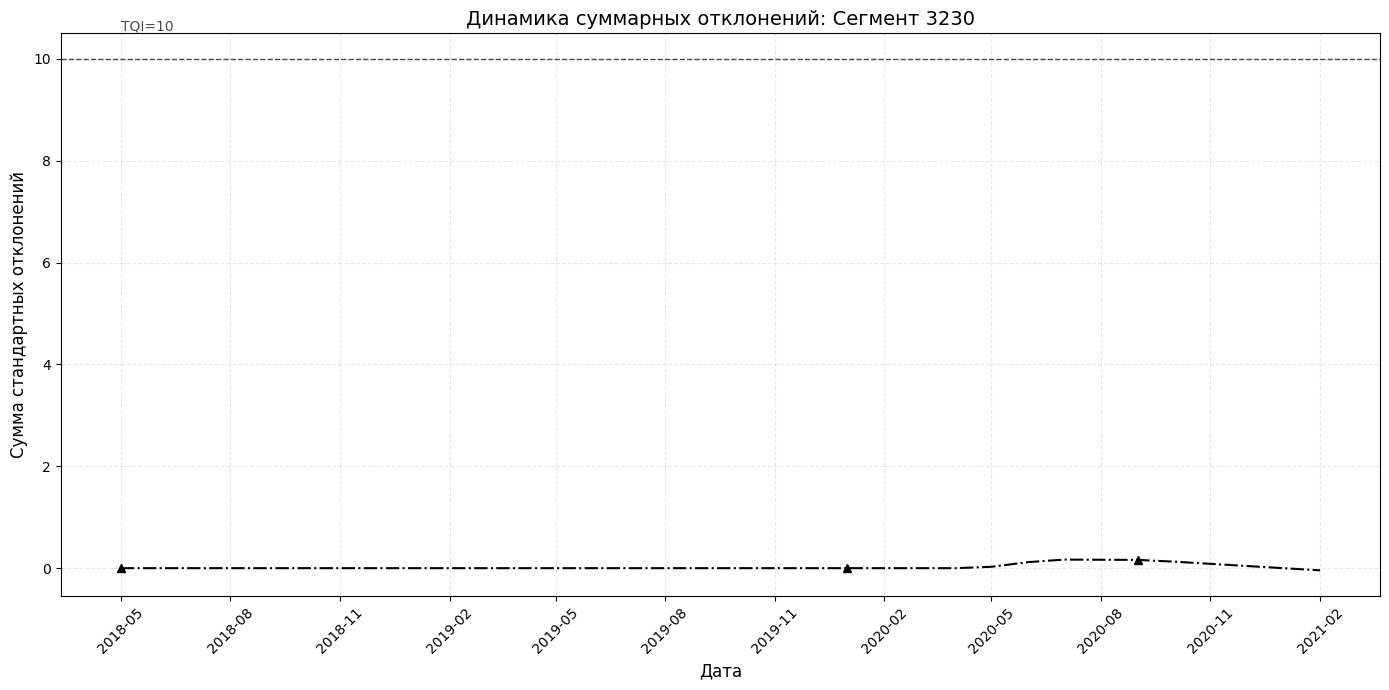

Сегмент 3231 пропущен (9 точек)


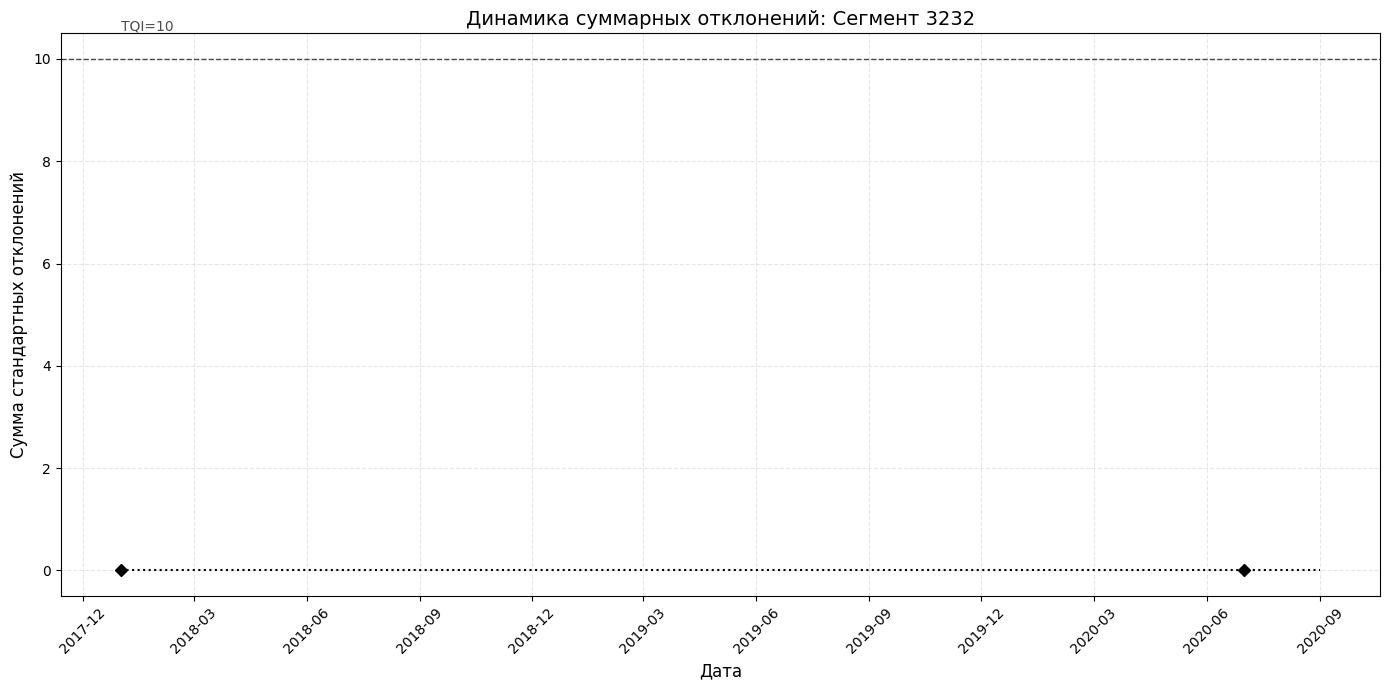

Сегмент 3233 пропущен (8 точек)
Сегмент 3234 пропущен (6 точек)
Сегмент 3235 пропущен (8 точек)
Сегмент 3236 пропущен (3 точек)


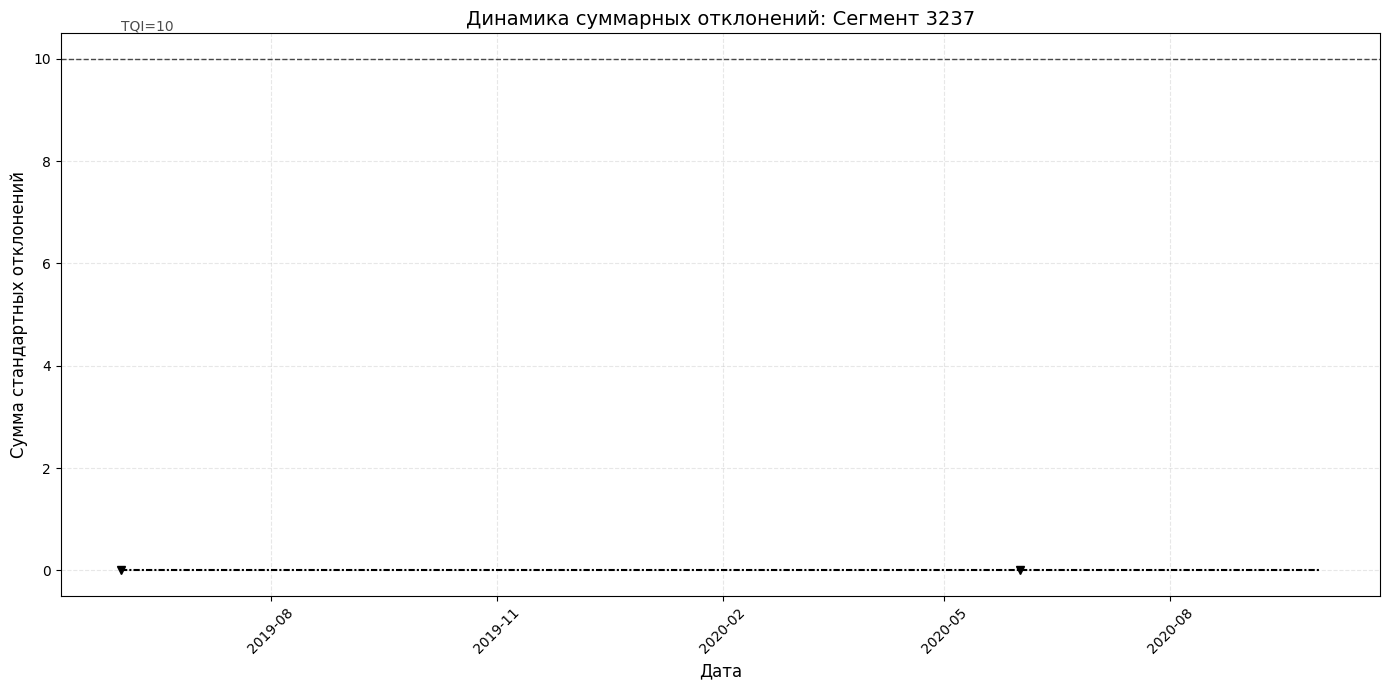

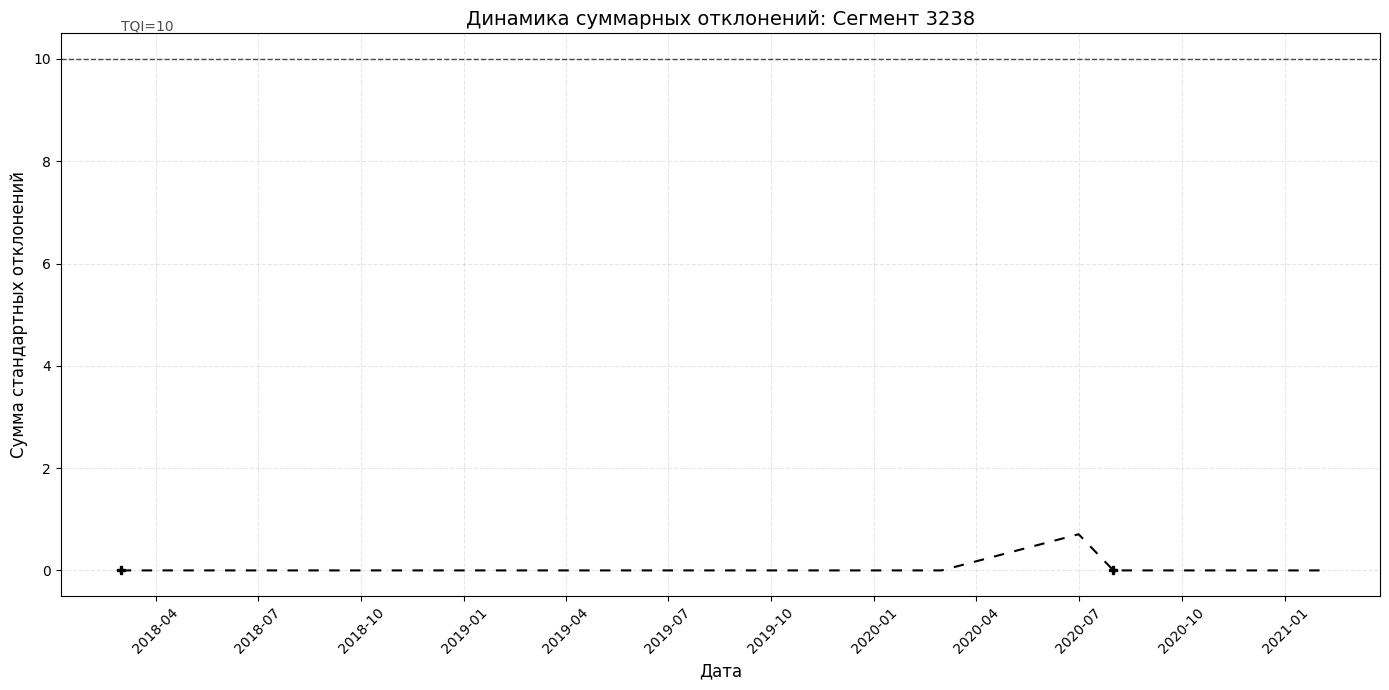

Сегмент 3239 пропущен (8 точек)
Сегмент 3240 пропущен (10 точек)
Сегмент 3241 пропущен (5 точек)
Сегмент 3242 пропущен (1 точек)
Сегмент 3243 пропущен (2 точек)
Сегмент 3244 пропущен (2 точек)


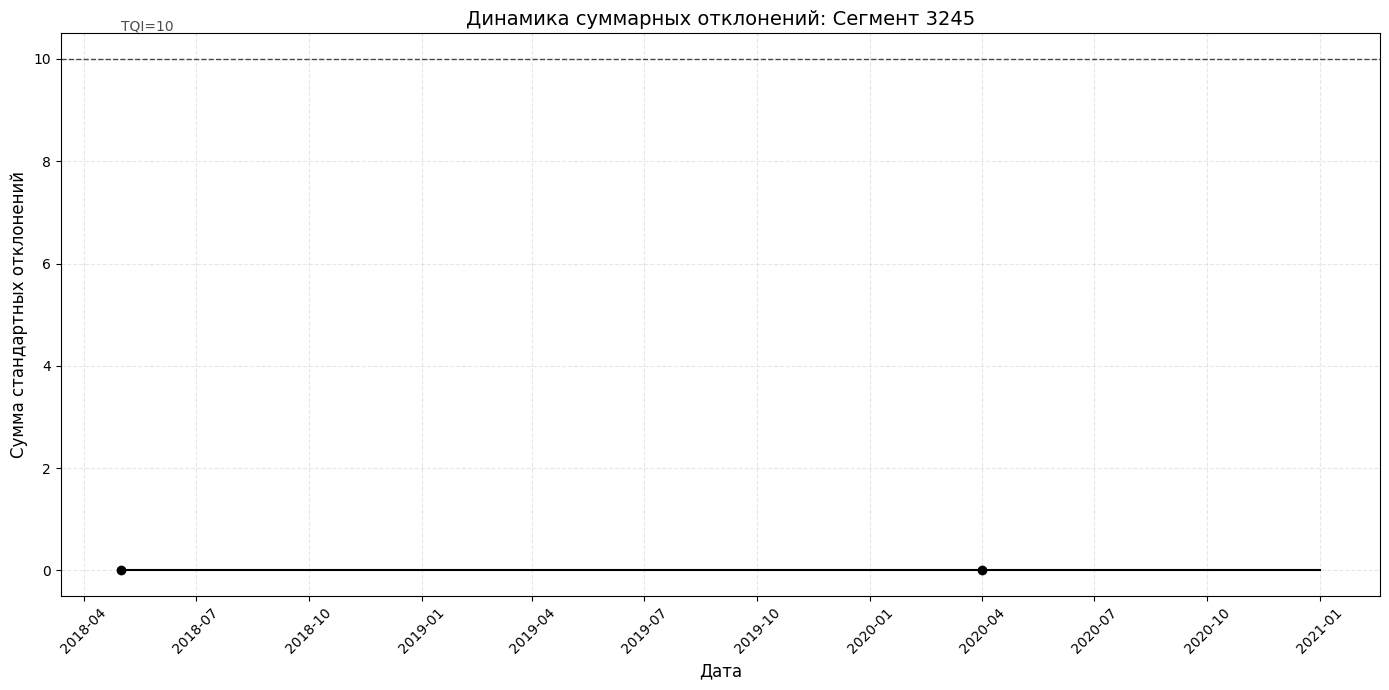

Сегмент 3246 пропущен (9 точек)
Сегмент 3247 пропущен (9 точек)


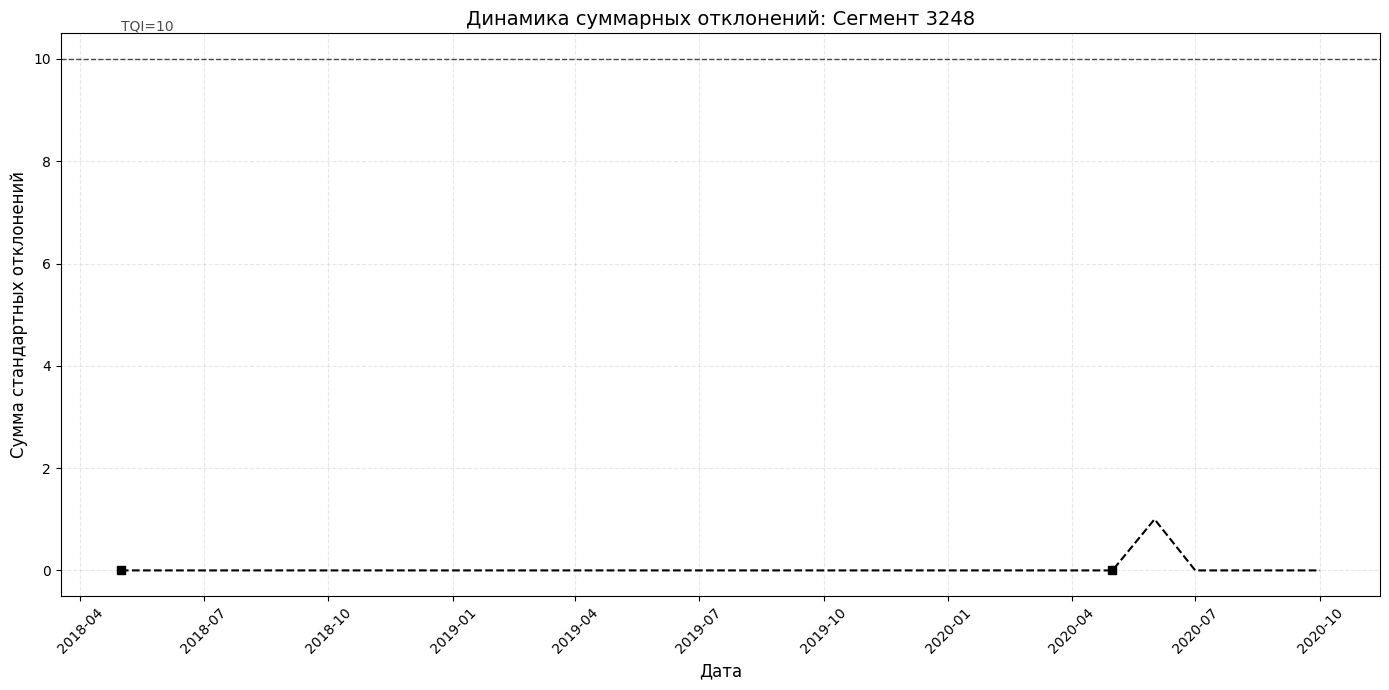

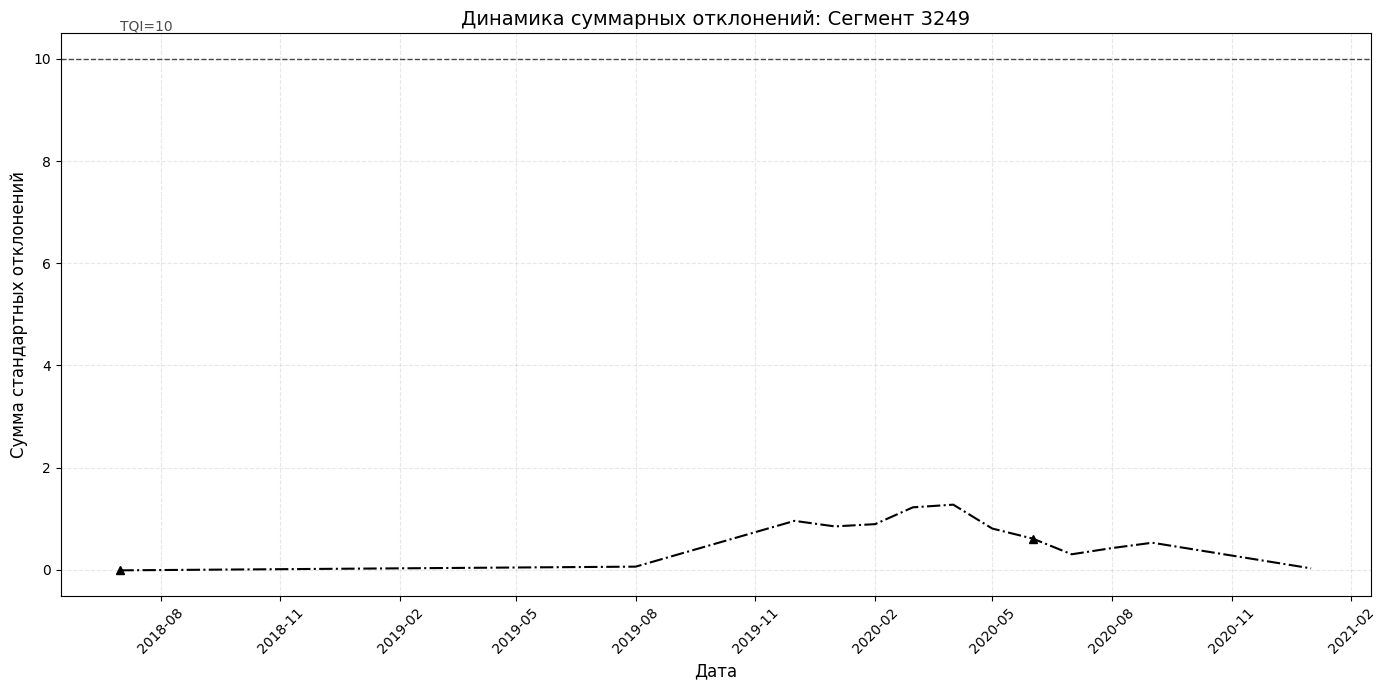

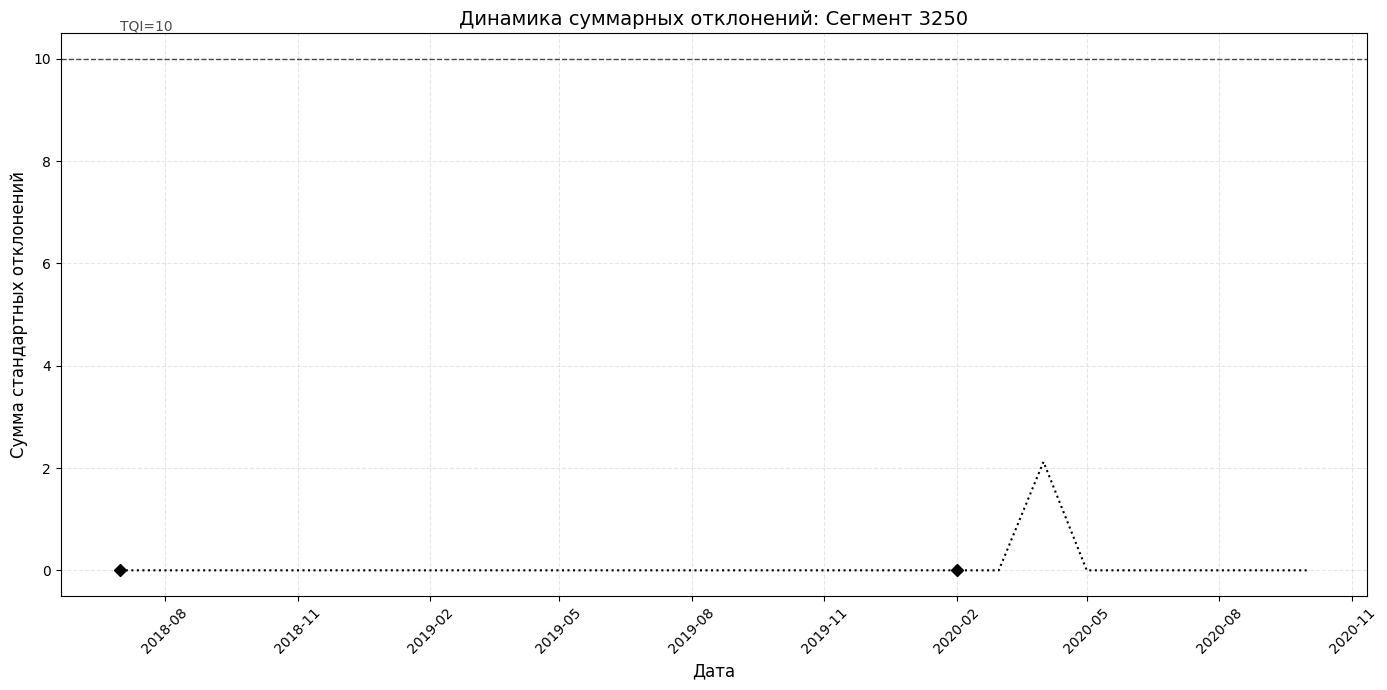

In [61]:

# Порог минимального количества точек для построения графика
threshold = 10

# Подготовка данных - суммируем отклонения по классам для каждого сегмента и месяца
segment_totals = monthly_weighted_std.groupby(['Сегмент', 'Месяц'])['Стандартное отклонение'].sum().reset_index()

# Добавляем числовое представление даты для сглаживания
segment_totals['date_num'] = mdates.date2num(segment_totals['Месяц'])

# Стили линий и маркеров
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5))]
markers = ['o', 's', '^', 'D', 'v', 'P']  # Разные маркеры для точек

# Счетчик сегментов, удовлетворяющих условию
valid_segments = 0

# Строим сглаженные кривые только для сегментов с достаточным количеством точек
for segment in sorted(segment_totals['Сегмент'].unique()):
    segment_data = segment_totals[segment_totals['Сегмент'] == segment]

    # Проверяем количество точек данных для сегмента
    if len(segment_data) <= threshold:
        print(f"Сегмент {segment} пропущен ({len(segment_data)} точек)")
        continue

    # Создаем новый график для каждого сегмента
    plt.figure(figsize=(14, 7))  # Все графики полноформатные

    # Применяем LOWESS-сглаживание
    smoothed = lowess(segment_data['Стандартное отклонение'],
                     segment_data['date_num'],
                     frac=0.4)

    # Строим сглаженную линию с уникальным стилем
    plt.plot(mdates.num2date(smoothed[:, 0]),
            smoothed[:, 1],
            label=f'Сегмент {segment}',
            linestyle=line_styles[valid_segments % len(line_styles)],
            marker=markers[valid_segments % len(markers)],
            markevery=8,
            color='black',
            linewidth=1.5,
            markersize=6)

    # Определяем какие пороги нужно отобразить
    max_deviation = segment_data['Стандартное отклонение'].max()

    # Всегда рисуем порог 10 если есть точки <=10
    if (segment_data['Стандартное отклонение'] <= 10).any():
        plt.axhline(y=10, color='black', linestyle='--', linewidth=1, alpha=0.7)

    # Рисуем порог 20 если есть точки >10 и <=20
    if (segment_data['Стандартное отклонение'] > 10).any() and (segment_data['Стандартное отклонение'] <= 20).any():
        plt.axhline(y=20, color='black', linestyle='--', linewidth=1, alpha=0.7)

    # Рисуем порог 30 если есть точки >=30
    if (segment_data['Стандартное отклонение'] >= 30).any():
        plt.axhline(y=30, color='black', linestyle='--', linewidth=1, alpha=0.7)

    # Добавляем аннотации для порогов
    plt.text(segment_data['Месяц'].min(), 10.5, 'TQI=10', va='bottom', ha='left', color='black', alpha=0.7)
    if (segment_data['Стандартное отклонение'] > 10).any():
        plt.text(segment_data['Месяц'].min(), 20.5, 'TQI=20', va='bottom', ha='left', color='black', alpha=0.7)
    if (segment_data['Стандартное отклонение'] >= 30).any():
        plt.text(segment_data['Месяц'].min(), 30.5, 'TQI=30', va='bottom', ha='left', color='black', alpha=0.7)

    # Настройки оформления графика
    plt.title(f'Динамика суммарных отклонений: Сегмент {segment}', fontsize=14)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Сумма стандартных отклонений', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)

    # Форматирование дат
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    valid_segments += 1

if valid_segments == 0:
    print("Нет сегментов с достаточным количеством данных для построения графика")